<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h1 align="center">I. Introduction & préparation des données</h1>

Dans ce notebook, nous nous concentrons sur l'exploration des images du jeu de données. L'objectif est d'analyser en détail les caractéristiques visuelles de ces images afin de mieux comprendre leur contenu. Cette exploration nous permettra d'extraire des informations pertinentes qui serviront de base pour la construction d'un premier modèle. Ce modèle sera conçu pour tirer parti des analyses effectuées durant cette phase exploratoire.

Nous commençons par charger le DataFrame précédemment enregistré à la fin de l’analyse textuelle. Ensuite, nous allons nettoyer les données en supprimant les produits identifiés comme potentiellement mal étiquetés définit lors du précédant notebook et les doublons d'images.

L’objectif de cette étape est de préparer un jeu de données cohérent et fiable, afin de pouvoir analyser de manière précise les caractéristiques visuelles des produits par catégorie.

In [1]:
import sys
import os
# Ajoute le répertoire parent (ou un autre chemin) à sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from features.images_transform import Cleaner, get_main_contours, Flattener, Resizer, CropTransformer, CornerCounter, ParallelogramCounter
from features.images_transform import ColorEncoder, ProportionTransformer, MeanRGBTransformer, HistRGBTransformer, MinMaxDiffTransformer
from features.images_transform import HOGTransformer, BoVWTransformer
from utils.utils import images_read, print_scores

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from skimage.feature import hog

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('../data/exploration/exploration.csv')

df = df[df['is_label_issue']==False]

ndup_images = df['hashed_image'].duplicated(keep=False).sum()
ndup_images_and_cat = df[['hashed_image', 'category']].duplicated(keep=False).sum()

print(f"Après la suppressions des produits tagués comme potentiellement mal labelisé, il reste {ndup_images} duplicata d'image.")
print(f"Parmis ces produits {ndup_images-ndup_images_and_cat} ont des doublons qui ne sont pas dans la même catégorie.")

df = df.drop_duplicates('hashed_image')

Après la suppressions des produits tagués comme potentiellement mal labelisé, il reste 7719 duplicata d'image.
Parmis ces produits 419 ont des doublons qui ne sont pas dans la même catégorie.


<div style="background:#f0f8ff; padding:12px; border-radius:6px">
    
On définit des fonctions pour récupérer les images à partir des chemins et une fonction pour afficher des grilles d'images. Ensuite, nous affichons quelques images pour chaque catégorie de manière aléatoire.

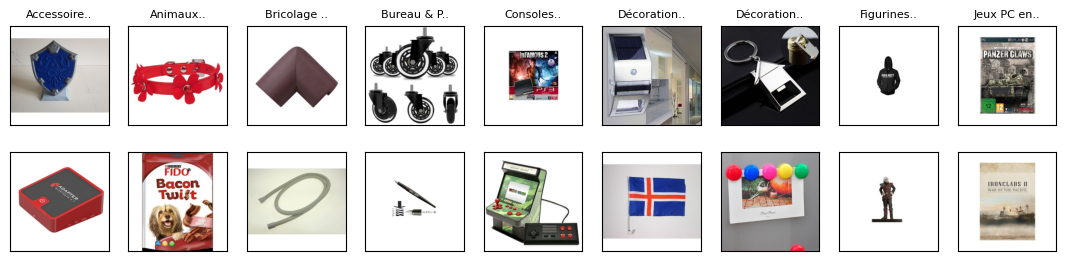

----------------------------------------------------------------------------------------------------------------------------------------------------


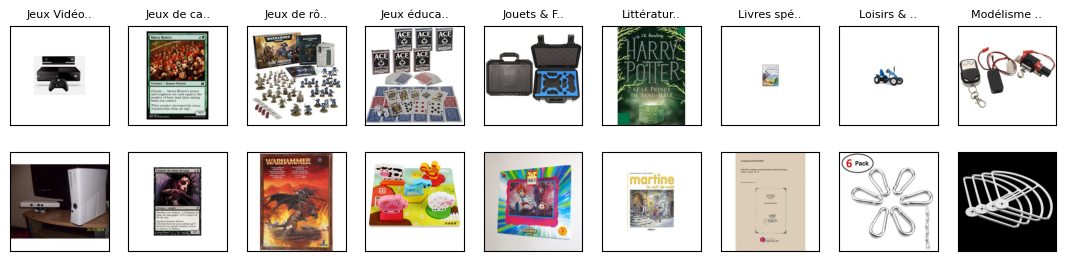

----------------------------------------------------------------------------------------------------------------------------------------------------


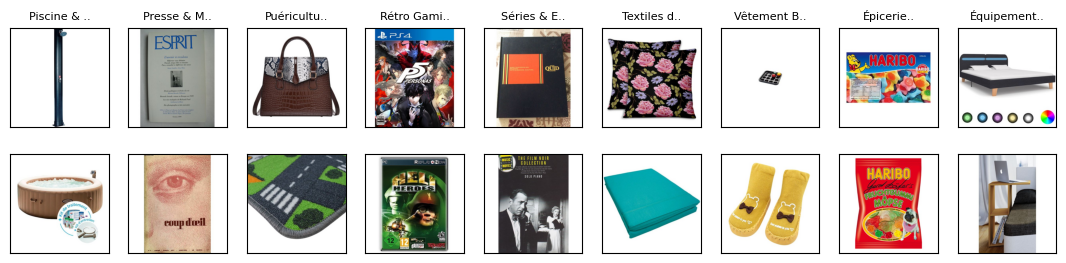

In [3]:
def images_grid(images, nrows=5, ncols=10, cmap=None, titles=None, ordered_by_rows=True, axes_size=(1.5, 1.5)):
    fig, axes = plt.subplots(nrows, ncols, figsize=(axes_size[0]*ncols, axes_size[1]*nrows))
    axes = axes.flatten()
    if ordered_by_rows:
        axes_order = range(nrows*ncols)
    else:
        axes_order = [i*ncols + j for j in range(ncols) for i in range(nrows)]
    for i in range(nrows*ncols):
        k = axes_order[i]
        if i < len(images):
            axes[k].imshow(images[i], cmap=cmap)
            if titles is not None:
                axes[k].set_title(titles[i], fontsize=8)
        axes[k].set_xticks([])
        axes[k].set_yticks([])
    plt.show()


N = 2  # nombre d'images par catégories

titles = []
paths = []

for cat in np.sort(df['category'].unique()):
    titles += [cat[:10]+'..'] + [''] * (N-1)
    paths += list(df[df['category'] == cat]['image'].sample(N, random_state=1))
# on utilise une fonction qui nous permet de récupérer le vecteur image correspondant aux chemins
images = images_read(paths)
images_grid(images[:9*N], N, 9, titles=titles[:9*N], ordered_by_rows=False)
print('-'*148)
images_grid(images[9*N:18*N], N, 9, titles=titles[9*N:18*N], ordered_by_rows=False)
print('-'*148)
images_grid(images[18*N:], N, 9, titles=titles[18*N:], ordered_by_rows=False)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">
    
<p>La plupart des images ont un fond blanc, mais ce n’est pas systématique. On observe également que le cadrage des objets varie : certains apparaissent très petits dans l’image.</p>

<p>Avant d’aller plus loin dans l’analyse, nous allons recadrer les images autour de l’objet principal.</p>

<p>Pour cela, nous commençons par détecter les contours des objets avec la fonction <code>get_main_contours</code>. Elle prend une image en entrée et applique les étapes suivantes :</p>
<ol>
  <li>Un flou gaussien pour atténuer les petites imperfections.</li>
  <li>Le filtre de Canny pour détecter les contours.</li>
  <li>Une dilatation suivie d’une érosion afin de combler les petits trous dans les contours détectés.</li>
</ol>

<p>Les contours sont récupérés avec <code>cv2.findContours</code> en mode hiérarchique (<code>cv2.RETR_TREE</code>), et la fonction retourne uniquement les contours principaux.</p>

<p>On ignore les contours trop plats (approximables par un segment) grâce au paramètre <code>min_vertex=3</code>.</p>


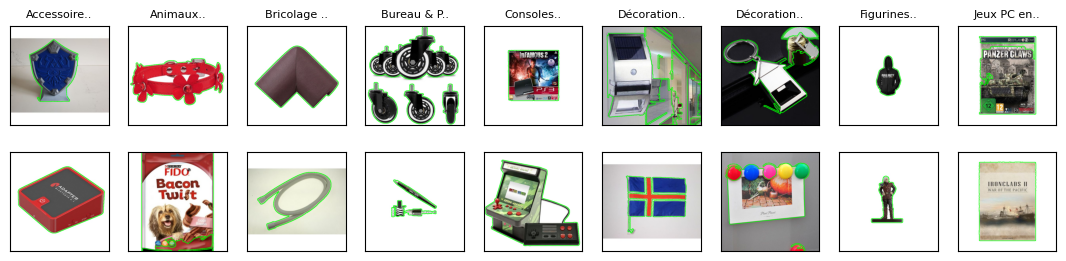

----------------------------------------------------------------------------------------------------------------------------------------------------


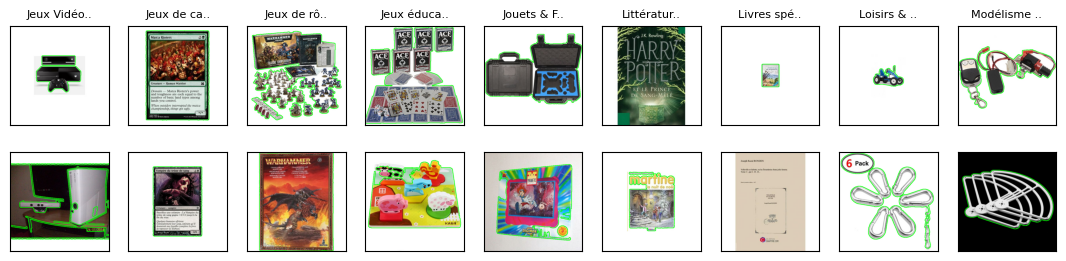

----------------------------------------------------------------------------------------------------------------------------------------------------


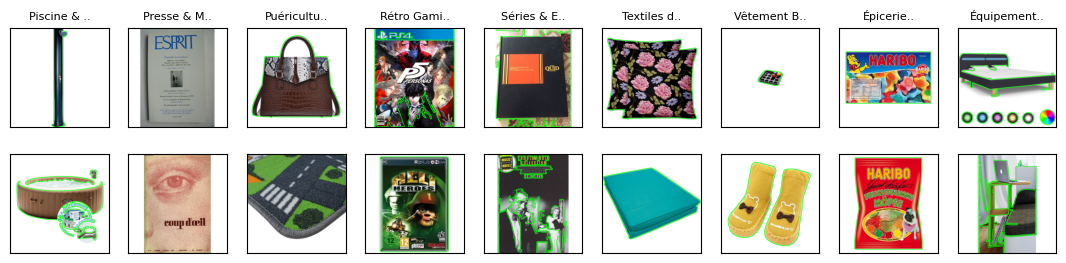

In [4]:
contours = get_main_contours(images, min_len=100, min_vertex=3, n_max_contours=7)
im_with_contours = []
for im, conts in zip(images, contours):
    im_copy = im.copy()
    cv2.drawContours(im_copy, conts, contourIdx=-1, color=(0, 255, 0), thickness=2)  # contour en vert
    im_with_contours.append(im_copy)
images_grid(im_with_contours[:9*N], N, 9, titles=titles[:9*N], ordered_by_rows=False)
print('-'*148)
images_grid(im_with_contours[9*N:18*N], N, 9, titles=titles[9*N:18*N], ordered_by_rows=False)
print('-'*148)
images_grid(im_with_contours[18*N:], N, 9, titles=titles[18*N:], ordered_by_rows=False)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

Nous allons maintenant masquer l’arrière-plan lorsque les contours de l’objet principal sont correctement détectés. Pour éviter de masquer l’image entière dans les cas où plusieurs contours plats ne ferment pas complètement l’objet, nous imposons un seuil maximal de surface à masquer. Concrètement, si la zone à masquer dépasse 70 % de l’image, nous ne faisons aucun masquage. Nous allons également recadré l'image autour du ou des contour detecté quand c'est le cas

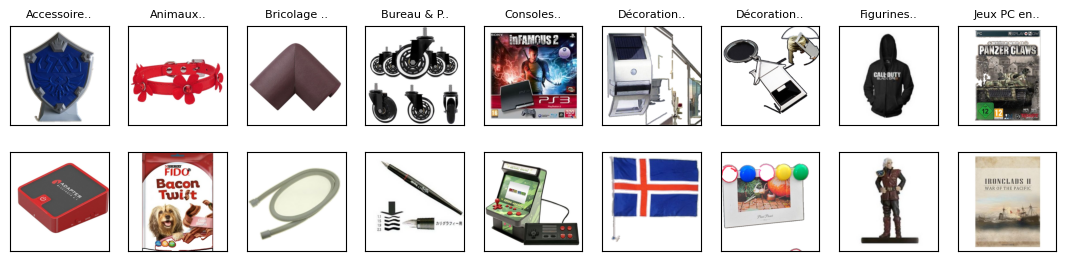

----------------------------------------------------------------------------------------------------------------------------------------------------


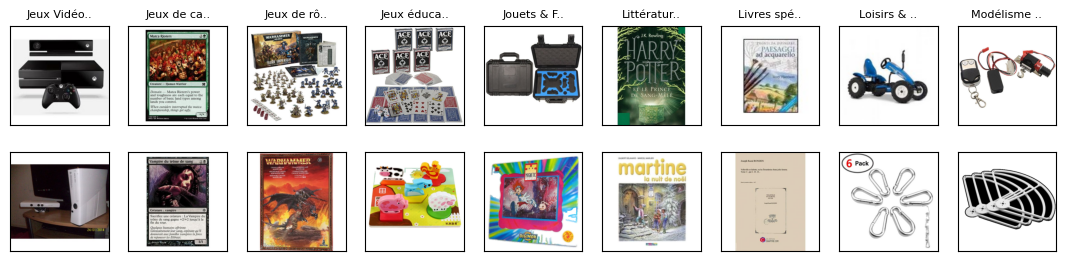

----------------------------------------------------------------------------------------------------------------------------------------------------


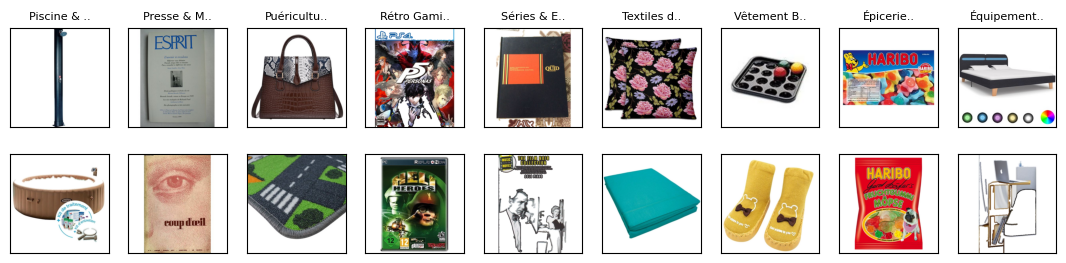

In [5]:
cleaner = Cleaner(max_bg_ratio=0.8, white_bg=True, padding=15, min_len_ratio=0.2, min_vertex=3, n_max_contours=6)
cropped_images = cleaner.fit_transform(images)

images_grid(cropped_images[:9*N], N, 9, titles=titles[:9*N], ordered_by_rows=False)
print('-'*148)
images_grid(cropped_images[9*N:18*N], N, 9, titles=titles[9*N:18*N], ordered_by_rows=False)
print('-'*148)
images_grid(cropped_images[18*N:], N, 9, titles=titles[18*N:], ordered_by_rows=False)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">
    
Malgrès quelque loupé dans la détection des contours certaines images sont moins polluées par l'environnement du produits.



Avant d'analyser les images par catégorie comme le chargement une par une des images jpeg est très long, nous allons enregistrer les vecteurs d'images numpy au format .npy nous pourrons ensuite les charger plus rapidement pour les analyses par catégories. Nous allons enregistrer les vecteurs d'images transformées (recadrage + masquage de l'arrière plan).

In [ ]:
# on va itérer sur l'ensemble des catégories
codes = np.array(sorted(df['prdtypecode'].unique()))
for code in codes:
    # Nous récupérons les images réduites pour que ça ne soit pas trop lourd en mémoire
    X = images_read(df[df['prdtypecode'] == code]['image'], (256, 256))
    # on applique la transformation
    X = cleaner.transform(X)
    # puis on enregistre le vecteur créé
    path = f"../data/exploration/images/{code}.npy"
    np.save(path, X)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

# <h1 align="center">II. Analyse des couleurs</h1>

Nous allons maintenant analyser la distribution de couleur par catégorie.



## <h2>2.1 Distribution des intensités par canal </h2>

Nous allons tracer les histogrammes rgb à l'aide de la fonction calcHist d'open CV à partir des vecteurs d'images de chaque catégorie.

In [6]:
# fonction permettant de récupérer l'histogramme sur l'ensembles des images passé en entrée

def get_rgb_hist(images):
    hist = np.zeros((3,256,1))
    for im in images:
        for channel in [0,1,2]:
            hist[channel] += cv2.calcHist([im],[channel],None,[256],[0,256])
    return hist

categories = np.array(sorted(df['category'].unique()))
# on récupère les codes ordonnés selon l'ordre des noms de catégorie
codes = np.array([
    df[df['category']==cat]['prdtypecode'].iloc[0]
    for cat in categories
])
# liste vide qui permettra de charger un histogramme par catégorie
hists = []
for code, cat in zip(codes, categories):
    # on charge le vecteur images de la categorie
    path = f"../data/exploration/images/{code}.npy"
    X = np.load(path)
    # puis on ajoute l'histogramme retourner par la fonction get_rgb_hist
    hists.append(get_rgb_hist(X))
hists = np.array(hists)

-----------------------------------------------------------------  histogrammes RGB  -----------------------------------------------------------------


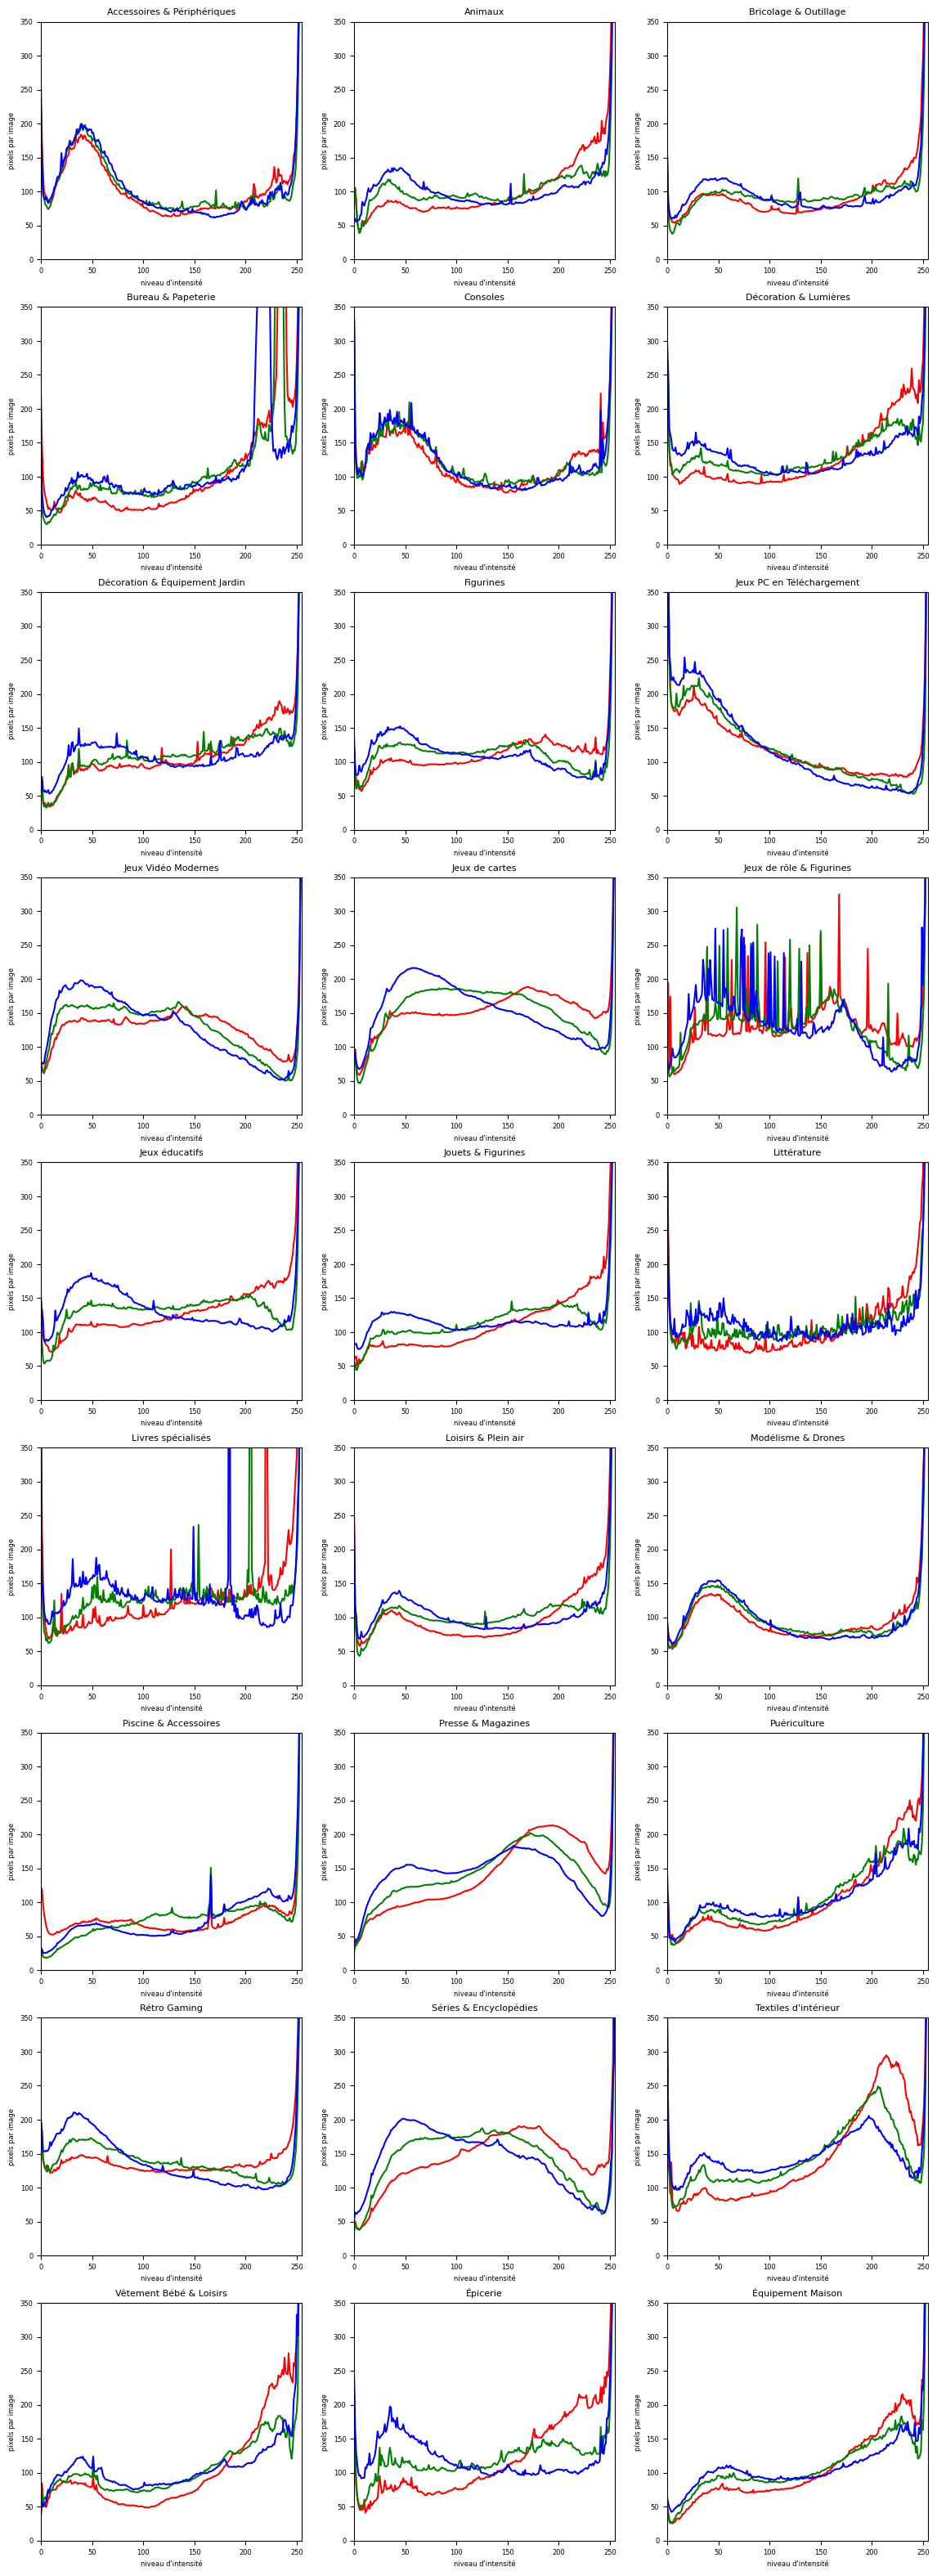

In [7]:
print('-'*65+"  histogrammes RGB  "+'-'*65)

cat_len = [len(df[df['category']==cat]) for cat in categories]

fig, axes = plt.subplots(9, 3, figsize=(14,40))
for i, ax in enumerate(axes.flatten()):
    for c, h in zip('rgb', hists[i]):
        n_images = cat_len[i]
        ax.plot(range(256), h / n_images, color=c)
        ax.set_title(categories[i], fontsize=8)
        ax.xaxis.set_tick_params(labelsize=6)
        ax.yaxis.set_tick_params(labelsize=6)
        ax.set_xlabel('niveau d\'intensité', fontsize=6)
        ax.set_ylabel('pixels par image', fontsize=6)
        ax.set_xlim(0,255)
        ax.set_ylim(0,350)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

On remarque que certaines catégories semblent avoir des images plus sombres, notamment celles liées aux consoles comme Accessoires, Rétro Gaming, Jeux PC et Jeux vidéo.

Dans la majorité des catégories, la composante rouge domine, tandis que le bleu est généralement moins présent — c’est particulièrement visible pour Séries & encyclopédies, Presse & magazines ou encore Textiles d’intérieur. À l’inverse, la catégorie Piscine se distingue par une forte présence de bleu.

On observe également que les histogrammes de certaines catégories, comme Littérature ou Livres spécialisés, présentent de nombreux pics, tandis que ceux d’autres catégories, comme Presse & magazines, sont beaucoup plus lisses.

Nous allons regarder plus en détaille à quoi correspond les trois plus grands pics de la catégorie Livres spécialisés.

In [8]:
hist = hists[categories == 'Livres spécialisés']
print("rouge (219 - 222)")
print(hist[0,0,219:223])
print("vert (203 - 206)")
print(hist[0,1,203:207])
print("bleu (183 - 185)")
print(hist[0,2,183:186])

rouge (219 - 222)
[[ 460851.]
 [2577274.]
 [1050146.]
 [ 403741.]]
vert (203 - 206)
[[ 387603.]
 [1111571.]
 [2613460.]
 [ 440215.]]
bleu (183 - 185)
[[ 401978.]
 [3097007.]
 [ 376218.]]


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

On observe des pics aux intensités 220, 205 et 184 pour le rouge, le vert et le bleu, respectivement.

Pour comprendre l’origine de ces pics, nous allons vérifier si ces intensités apparaissent sur les mêmes pixels, si la couleur résultante est fréquente dans de nombreuses images, et si elle correspond à des produits similaires.

Pour cela, nous filtrerons les produits dont plus de 30 % des pixels présentent cette couleur.

nombre de pixels de la couleur (220,205,184) dans les livres spécialisés : 2093984
Cela représente 74.5% des pixels r=220 du pic de vert de l'histogramme rgb
C'est 1.3% des pixels de la catégorie 'Livres spécialisés'


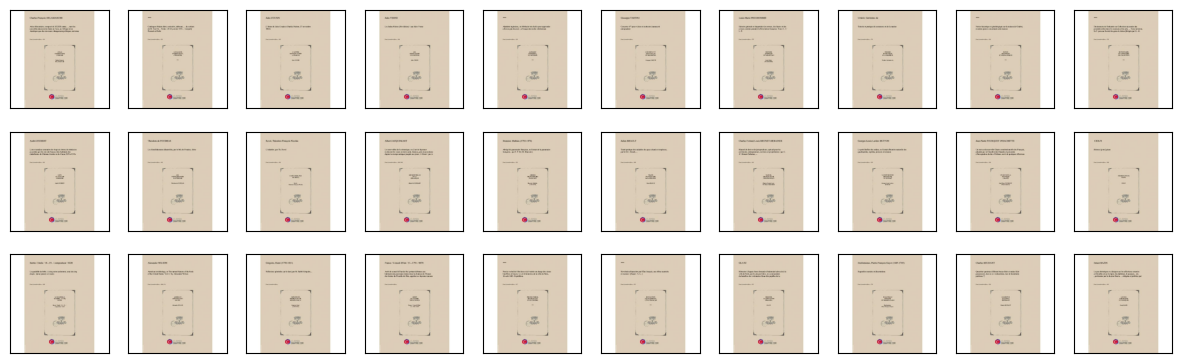

In [9]:
# on récupère les images de la catégorie
code = codes[categories == 'Livres spécialisés'][0]
path = f"../data/exploration/images/{code}.npy"
X = np.load(path)

# on récupère les valeurs des pics
r, g, b = 220, 205, 184
color = np.array([220, 205, 184])

# puis

n_pixs = (X == color).all(axis=3).sum()
print(f"nombre de pixels de la couleur (220,205,184) dans les livres spécialisés : {n_pixs}")
print(f"Cela représente {n_pixs/2810333:.1%} des pixels r=220 du pic de vert de l'histogramme rgb")
print(f"C'est {n_pixs/ (X.shape[0]*X.shape[1]*X.shape[2]):.1%} des pixels de la catégorie 'Livres spécialisés'")

rate_by_im = (X == color).all(axis=3).sum(axis=2).sum(axis=1) / (X.shape[1]*X.shape[2])
mask = rate_by_im > 0.3
images_grid(X[mask],3)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">
    
Nous remarquons ici que cette couleur est caractèristique d'un type d'ouvrage spécialisé qui semble beaucoup vendu sur Rakuten. Ces produits expliquent les trois pics sur l'histogramme de Livres spécialisés.

<p>
L'histogramme d'une image contenant un objet de couleur uniforme, c'est-à-dire avec peu ou pas de variation de teinte (très monochrome), présentera un pic prononcé aux trois intensités correspondant à cette couleur. Pour identifier un tel objet monochrome, on peut analyser son histogramme en examinant les différences maximales de la quantité de pixels entre les différentes intensités successives. De fortes variations dans ces différences correspondent à des pics sur l'histogramme. Si les trois canaux de couleur présentent des pics significatifs, cela indique qu'une grande partie de l'image est effectivement monochrome.
</p>

<p>
Nous allons utiliser les transformateurs <code>HistRGBTransformer</code>, qui génère le vecteur d'histogramme pour les images fournies en entrée, et <code>MinMaxDiffTransformer</code>, qui extrait la valeur minimale des différences maximales sur les intervalles de colonnes correspondant à chaque canal. Ensuite, nous afficherons les graphiques montrant les valeurs moyennes obtenues pour chaque catégorie. Pour éviter de capturer les pics des arrière-plans blanc ou noir, nous allons nous restreindre aux intervalles d'intensité compris entre 15 et 240 pour les trois canaux RGB.
</p>


In [10]:
# liste vide qui permettra de charger un histogramme par catégorie

m, M = 15, 240
# les intervalles ou l'on regarde les différences max
max_diff_ranges = [[i*(M-m), (i+1)*(M-m)] for i in range(3)]
mean_min_max_pics = []
histrgb = HistRGBTransformer(histSize=[M-m], ranges=[[m,M]]*3)
min_max_diff = MinMaxDiffTransformer(max_diff_ranges=max_diff_ranges)
for code, cat in zip(codes, categories):
    # on charge le vecteur images de la categorie
    path = f"../data/exploration/images/{code}.npy"
    X = np.load(path)
    # puis on ajoute l'histogramme retourner par la fonction get_rgb_hist
    X = histrgb.fit_transform(X)
    X = min_max_diff.fit_transform(X)
    mean_min_max_pics.append(X.mean())
mean_min_max_pics = np.array(mean_min_max_pics)


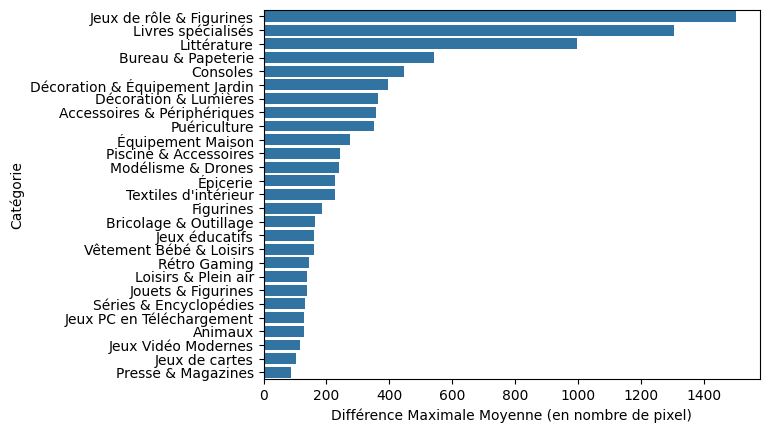

In [11]:
data = pd.DataFrame({'Catégorie':categories, 'Différence Maximale Moyenne':mean_min_max_pics}).sort_values('Différence Maximale Moyenne', ascending=False)
sns.barplot(data=data, x='Différence Maximale Moyenne', y='Catégorie', orient='h')
plt.xlabel('Différence Maximale Moyenne (en nombre de pixel)');

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

Les résultats sont cohérents avec ce que nous avons observé dans les précédents histogrammes. Les trois catégories présentant les pics les plus marqués sont effectivement Jeux de rôle, Livres spécialisés et Littérature. Nous allons donc utiliser ces données comme features de notre modèle. De plus, nous allons également utiliser les histogrammes découpés en 16 intervalles.

In [28]:
# 3 histogrammes de 16 blocs d'intensités de couleur (0-15, 16-31, ..., 240-255) => 48 features
histrgb = HistRGBTransformer(histSize=[16])

# permet de détecter les images avec des pics d'intensités sur l'intervalle [15,240]**3
# => 1 feature représentant la plus petite différence maximum à travers les 3 canaux

# ici histrgb va sortir une matrice de 3 x 225 colonnes pour les niveaux d'intensités de chaque canaux (entre 15 et 240)
# nous allons chercher les différences maximums le long des niveaux d'intensités sur les 3 canaux

m, M = 15, 240
# les intervalles ou l'on regarde les différences max
max_diff_ranges = [[i*(M-m), (i+1)*(M-m)] for i in range(3)]
hist_diff_pipeline = Pipeline(steps=[('histrgb',  HistRGBTransformer(histSize=[M-m], ranges=[[m,M]]*3)),
                                     ('min_max_diff', MinMaxDiffTransformer(max_diff_ranges=max_diff_ranges)),
                                     ('scaler', StandardScaler())])

<div style="background:#f0f8ff; padding:12px; border-radius:6px">
    
## <h2>2.2 Segmentation des couleurs dans les images<h2>

Jusqu’ici, nous avons examiné séparément la distribution des intensités de chaque canal (rouge, vert, bleu) à l’aide des histogrammes RGB. Cette analyse permet d’identifier certaines tendances, comme la présence de pics d’intensité, mais elle ne rend compte que partiellement de la couleur réelle des pixels : en effet, un pixel est déterminé par la combinaison simultanée des trois canaux.

Pour obtenir une vision plus pertinente des couleurs réellement présentes dans les images, nous passons maintenant à une analyse dans l’espace 3D des couleurs (R, G, B). Au lieu de considérer chaque canal indépendamment, nous regroupons les pixels selon des intervalles définis dans cet espace, chacun correspondant à une couleur perceptuelle : noir, blanc, gris, rouge, orange, jaune, vert, turquoise, cyan, bleu, violet et rose.

Concrètement, chaque pixel est encodé selon l’intervalle auquel il appartient. Cela nous permet d’identifier les couleurs dominantes par catégorie d’images, de manière beaucoup plus cohérente avec la perception humaine que l’analyse canal par canal. Pour cela nous utilisons la classe ColorEncoder.

Voici quelques exemples d’images recolorées, où chaque pixel prend la couleur représentative du centre de l’intervalle auquel il a été associé.

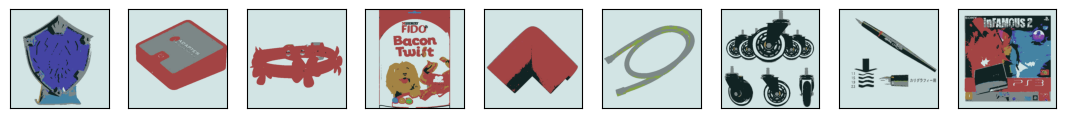

----------------------------------------------------------------- sans recoloration -----------------------------------------------------------------


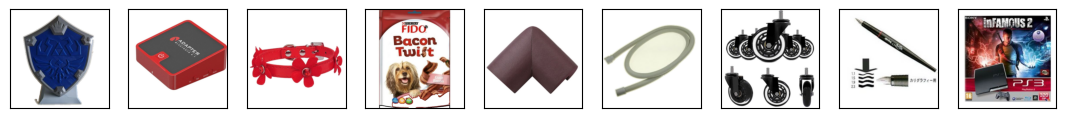

In [13]:
encoder = ColorEncoder()
enc_images = encoder.fit_transform(cropped_images)
# on récupère la couleur centrale de chaque intervalle de couleur définit dans l'encoder de couleur
rgb_centroids = encoder.get_centroids(rgb=True)
centroids_images = rgb_centroids[0][enc_images]
images_grid(centroids_images[:9], 1, 9)
print('-'*65 +' sans recoloration '+'-'*65)
images_grid(cropped_images[:9], 1, 9)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">
Nous allons maintenant analyser, pour chaque catégorie, la proportion de pixels appartenant à chacune de ces classes de couleurs. Cette étape permet d’identifier les teintes dominantes au sein des catégories.

In [15]:
# permet de récupérer les proportions parmis toutes les valeurs encodées
prop_all = ProportionTransformer()
# permet de récupérer les proportions parmis toutes les valeurs encodées (hormis noir, gris, blanc qui sont encodé par 0,1,2)
prop_only_colors = ProportionTransformer(categories=range(3,12))

# liste vide qui permettra de charger un histogramme par catégorie
rates = []
rates_only_colors = []
# pour que ça ne soit pas trop long
resizer = Resizer(dsize=(64,64))

for code, cat in zip(codes, categories):
    # on charge le vecteur images de la categorie puis on applatit les images
    path = f"../data/exploration/images/{code}.npy"
    X = np.load(path)
    X = resizer.fit_transform(X)
    X = encoder.transform(X).reshape(len(X), -1)
    # on récupère les proportions moyennes
    X_all = prop_all.fit_transform(X)
    rates.append(X_all.mean(axis=0))
    X_only_colors = prop_only_colors.fit_transform(X)
    rates_only_colors.append(X_only_colors.mean(axis=0))

rates = np.array(rates)
rates_only_colors = np.array(rates_only_colors)

# ici on normalise car le tranformateur renvoie un vecteur nul pour chaque image
# ou aucune couleur n'est présente
rates_only_colors = (rates_only_colors / rates_only_colors.sum(axis=1).reshape(27,1))

In [36]:
idx1 = np.argsort(rates[:,:3].sum(axis=1))
rates = rates[idx1]

idx2 = np.argsort(rates_only_colors[:,:5].sum(axis=1))
rates_only_colors = rates_only_colors[idx2]

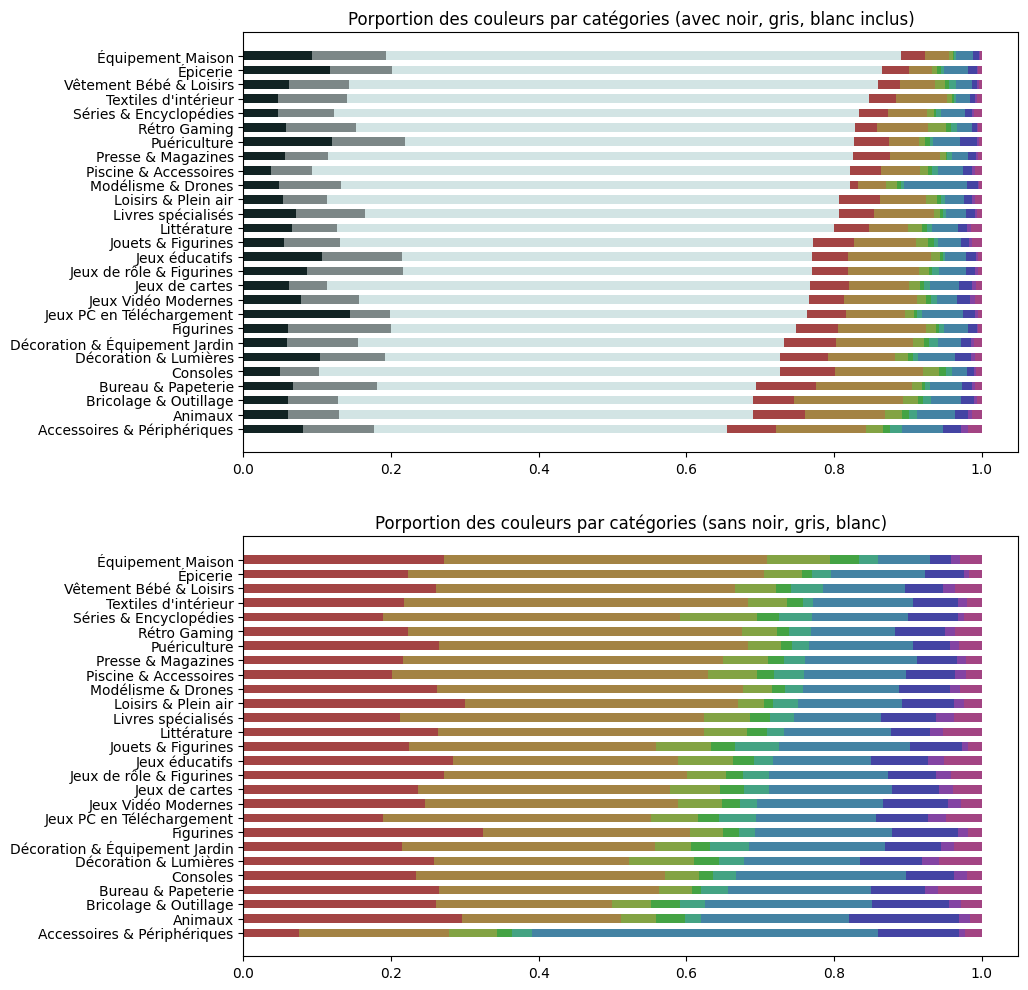

In [37]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,12))

bottom = np.zeros(len(categories))
for color_code in range(rates.shape[1]):
    r, g, b = rgb_centroids[0][color_code]/255
    ax1.barh(categories[idx1], rates[:,color_code], left=bottom, height=0.6, color=(r,g,b))
    bottom += rates[:,color_code]
ax1.set_title('Porportion des couleurs par catégories (avec noir, gris, blanc inclus)')
#plt.xticks(rotation=90)
#plt.show()
bottom = np.zeros(len(categories))

for color_code in range(rates_only_colors.shape[1]):
    # l'encodage des couleurs commence après blanc, gris, noir donc à partir de 3.
    r, g, b = rgb_centroids[0][color_code+3]/255
    ax2.barh(categories[idx2], rates_only_colors[:,color_code], left=bottom, height=0.6, color=(r,g,b))
    bottom += rates_only_colors[:,color_code]
ax2.set_title('Porportion des couleurs par catégories (sans noir, gris, blanc)')
# plt.xticks(rotation=90)
plt.show()

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

On observe que certaines catégories présentent des images plus colorées que d’autres, comme Jeux de cartes ou Livres. La répartition des couleurs est globalement assez équilibrée, à l’exception de la catégorie Piscine, où le bleu domine nettement.

Nous allons maintenant mettre en place un pipeline permettant de calculer les proportions de couleurs dans les images.

In [29]:
# taux de couleur par image en fonction de range de 9 couleurs prédéfinie dans ColorEncoder() => 9 features
colors_rate_pipeline = Pipeline(steps=[('resizer', Resizer(dsize=(32, 32))),
                                       ('color_encoder', ColorEncoder()),
                                       ('flattener', Flattener()),
                                       ('proportion', ProportionTransformer(categories=range(3,12)))])

<div style="background:#f0f8ff; padding:12px; border-radius:6px">


# <h1 align="center">III. Détection des formes</h1>
## <h2>3.1. Analyse des moyennes d’intensité</h2>
Nous allons commencer par afficher les images des moyennes et des écart-types par catégorie pour voir si on y voit des formes.

-----------------------------------------------------------------  moyennes  -----------------------------------------------------------------


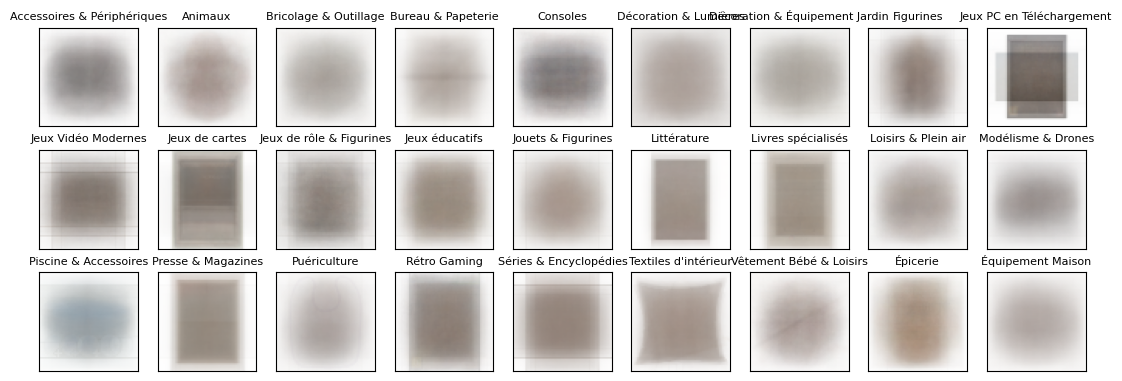

-----------------------------------------------------------------  écart-types  -----------------------------------------------------------------


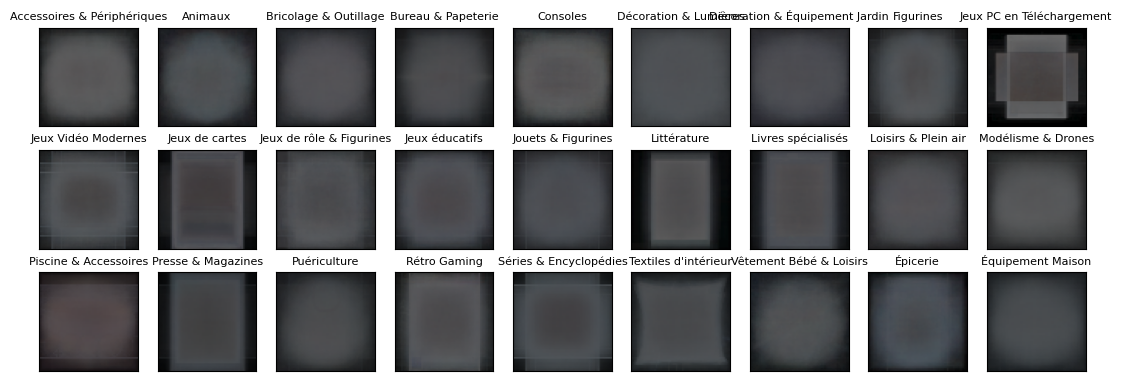

In [26]:
images_means = []
images_std = []

resizer = Resizer(dsize=(64,64))

for code, cat in zip(codes, categories):
    # on charge le vecteur images de la categorie puis on applatit les images
    path = f"../data/exploration/images/{code}.npy"
    X = np.load(path)
    # on reduit les images pour éviter que les calculs qui suivent soit trop long
    X = resizer.fit_transform(X)
    # on récupère la moyenne des images et leurs écart-types
    images_means.append(X.mean(axis=0).astype('uint8'))
    images_std.append(X.std(axis=0).astype('uint8'))

print('-'*65+"  moyennes  "+'-'*65)
images_grid(images_means, 3, 9, titles=categories)
print('-'*65+"  écart-types  "+'-'*65)
images_grid(images_std, 3, 9, titles=categories)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
L’image moyenne de la catégorie <em>Piscine</em> confirme la prédominance du bleu observée dans les graphiques précédents&nbsp;: elle apparaît globalement plus bleutée.
</p>

<p>
Nous remarquons également que les catégories où les formes ressortent le plus nettement sont celles des <em>Livres</em> et des <em>Jeux PC</em>, caractérisées par des formes rectangulaires. On observe d’ailleurs plusieurs formats de rectangles&nbsp;: des formes proches du carré dans la catégorie <em>Jeux de cartes</em>, tandis que celles de la catégorie <em>Littérature</em> sont davantage allongées.
</p>

## <h2>3.2. Détection et classification des parallélogrammes</h2>

<p>
Pour aller plus loin, nous allons compter les parallélogrammes détectés en fonction de leur format grâce au transformateur <code>ParallelogramCounter</code>, qui renvoie le nombre de parallélogrammes identifiés selon des intervalles de ratios définis par la longueur divisée par la largeur.
</p>

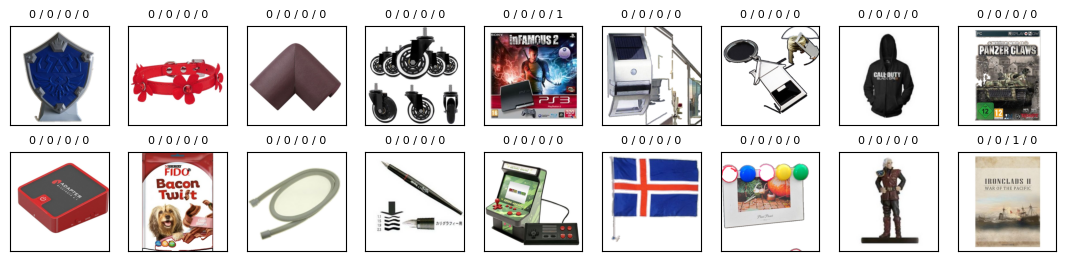

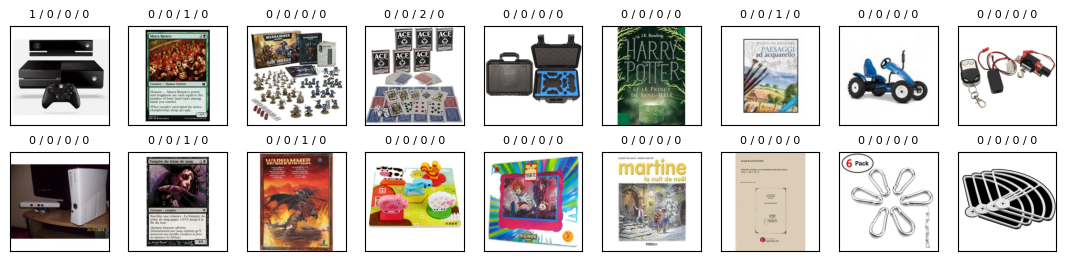

In [40]:
counter = ParallelogramCounter(bins=[0,0.3,0.6,0.8,1.1])
X = counter.fit_transform(cropped_images)
counter_titles = pd.DataFrame(X.astype('int')).astype('str').apply(lambda x : x[0] + ' / ' + x[1] + ' / ' + x[2] + ' / ' + x[3], axis=1)
images_grid(cropped_images[:9*N], N, 9, titles=list(counter_titles[:9*N]), ordered_by_rows=False)
images_grid(cropped_images[9*N:18*N], N, 9, titles=list(counter_titles[9*N:18*N]), ordered_by_rows=False)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
Les quatre chiffres affichés au-dessus des images représentent respectivement le nombre de parallélogrammes dont le ratio longueur/largeur se situe dans les intervalles suivants&nbsp;: 
<em>0&nbsp;à&nbsp;0.3</em>, <em>0.3&nbsp;à&nbsp;0.6</em>, <em>0.6&nbsp;à&nbsp;0.8</em> et <em>0.8&nbsp;à&nbsp;1</em>.
</p>


Le jeux PC en haut à droite n'est pas detecté n'est pas detecté (surment à cause du blanc au dessus du titre qui ne permet pas de bien detecté le contour, il y a également des livres non detecté mais calà semble bien marcher pour les cartes.

In [41]:
# récupère le taux d'image avec aucun rectangle detecté, avec un rectangle detecté ou avec plusieurs rectangles detectés par catégorie
rates = []
shares = []

resizer = Resizer(dsize=(128,128))

for code, cat in zip(codes, categories):
    # on charge le vecteur images de la categorie puis on applatit les images
    path = f"../data/exploration/images/{code}.npy"
    X = np.load(path)
    # on reduit les images pour éviter que les calculs qui suivent soit trop long
    X = resizer.fit_transform(X)
    X = counter.transform(X)
    # proportion d'image avec 0, 1 ou plusieurs parallèlogrammes detéctés par catégorie
    total = X.sum(axis=1)
    rates.append([(total == 0).mean(), (total == 1).mean(), (total > 1).mean()])
    # parmis les parallèlogrammes les proportions de chaque intervalle de format
    shares.append(X.sum(axis=0)/X.sum())

rates = np.array(rates)
shares = np.array(shares)

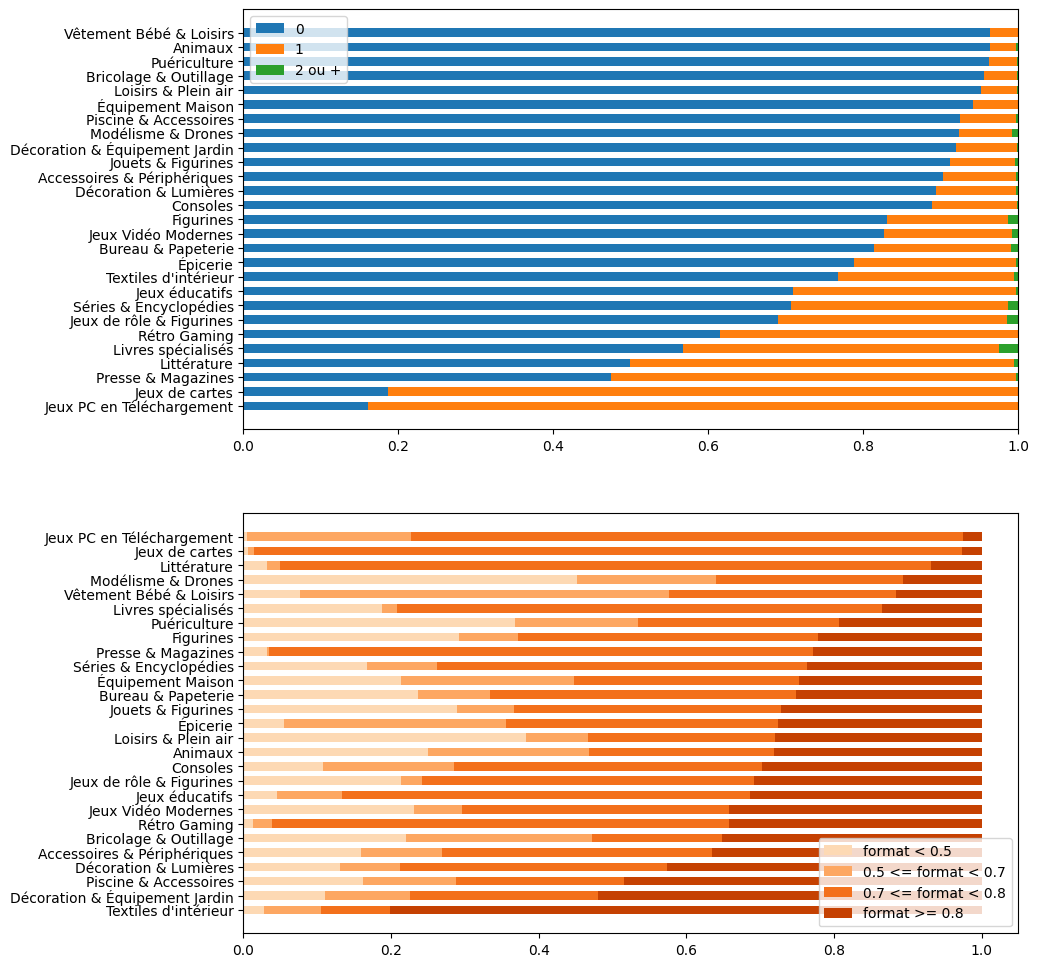

In [42]:
idx1 = np.argsort(rates[:,0])
idx2 = np.argsort(shares[:,:3].sum(axis=1))
colormap = plt.cm.Oranges # Tu peux essayer 'viridis', 'plasma', 'inferno', 'cividis', etc.
colors = [colormap(i / 5) for i in range(1,5)]

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,12))

bottom = np.zeros(len(categories))
labels = ['0', '1', '2 ou +']
for i in range(rates.shape[1]):
    ax1.barh(categories[idx1], rates[idx1][:,i], left=bottom, height=0.6, label=labels[i])
    bottom += rates[idx1][:,i]
ax1.legend()

bottom = np.zeros(len(categories))
labels = ['format < 0.5', '0.5 <= format < 0.7', '0.7 <= format < 0.8', 'format >= 0.8']
for i in range(shares.shape[1]):
    ax2.barh(categories[idx2], shares[idx2][:,i], left=bottom, height=0.6, label=labels[i], color=colors[i])
    bottom += shares[idx2][:,i]
ax2.legend()
plt.show()

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
Ce graphique confirme les observations faites sur les images moyennes&nbsp;: dans plus de 70&nbsp;% des images des catégories <em>Jeux PC</em> et <em>Jeux de cartes</em>, des parallélogrammes sont détectés, le plus souvent avec un format compris entre 0.6 et 0.8.
</p>

<p>
La catégorie <em>Textile d’intérieur</em> se distingue par des formes détectées beaucoup plus proches du carré. Il s’agit très probablement de coussins identifiés comme des parallélogrammes.
</p>

<p>
Ces éléments suggèrent qu’il serait pertinent d’intégrer ces caractéristiques (features) dans notre pipeline final.
</p>


In [24]:
# retourne le nombre de parallèlogramme detecté en fonction de leur formats (ici définit par leur largeur divisé par leur longueur) 
# sur 4 intervalles correspondant au rectangle très allongés < 0.3, allongé entre 0.3 et 0.6, peu allongé entre 0.6 et 0.8
# et proche d'être un carré entre 0.8 et 1

parallelogram_counter = ParallelogramCounter(min_perimeter=100, bins=[0,0.3,0.6,0.8,1.1])

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h2>3.3. Détecteur de coins Harris</h2>
<p> Pour détecter les angles des images, nous allons utiliser la méthode de Harris. Le détecteur de Harris repose sur l’analyse des variations d’intensité dans une petite zone de l’image : lorsqu’un déplacement dans plusieurs directions modifie fortement l’intensité, le point est considéré comme un « coin ». Cette méthode permet ainsi d’identifier des points d’intérêt stables et robustes pour l’analyse d’images. </p>

<p>Voici un petit aperçu du rendu de cette méthode en appliquant en vert les pixels qui sont détectés comme des coins.</p>


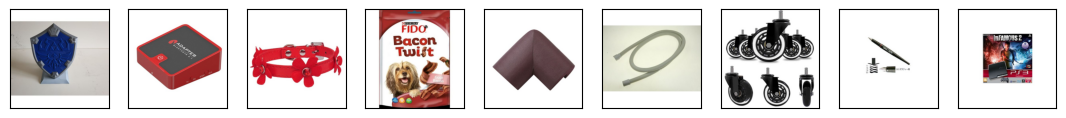

----------------------------------------------------------------------------------------------------------------------------------------------------


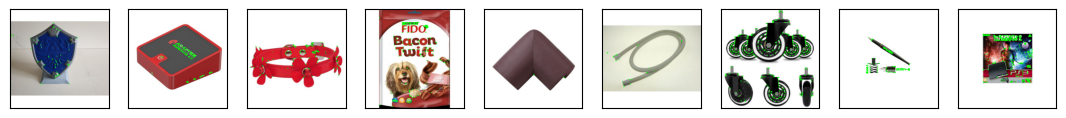

In [32]:
# seuil de 1% du maximum des dis
th = 0.01

harris_ims = images[:9].copy()
for im in harris_ims:
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    # cv2.cornerHarris retourne la carte de réponses du détecteur de Harris (elle reflète à quel point un pixel est un coin)
    dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.05)
    dst = cv2.dilate(dst,None)
    is_corner = dst > th*dst.max()
    # on les affiches en vert
    im[is_corner] = [0,255,0]

images_grid(images[:9], 1, 9)
print('-'*148)
images_grid(harris_ims, 1, 9)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

Nous allons compter le nombre de points detécté en moyenne par catégorie.

In [33]:
counter = CornerCounter(block_size=2, ksize=3, threshold=0.05)
counts = []
for code, cat in zip(codes, categories):
    # on charge le vecteur images de la categorie puis on applatit les images
    path = f"../data/exploration/images/{code}.npy"
    X = np.load(path)
    X = counter.fit_transform(X)
    counts.append(X.mean())

counts = np.array(counts)

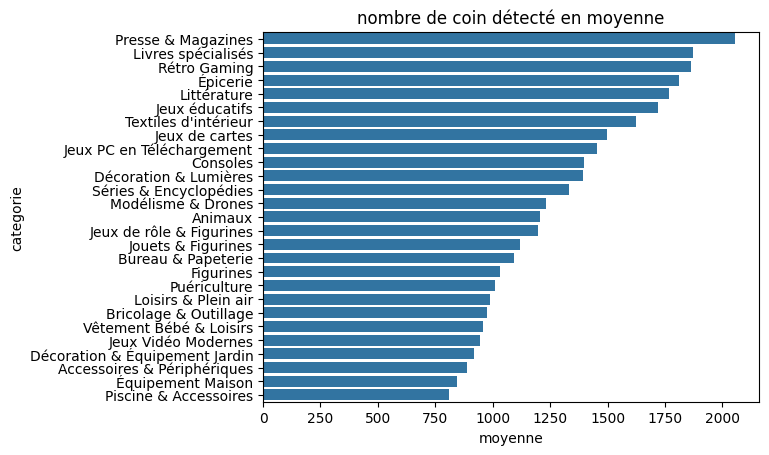

In [34]:
data = pd.DataFrame({'categorie':categories, 'moyenne':counts}).sort_values('moyenne', ascending=False)
sns.barplot(data=data, y='categorie', x='moyenne', orient='h')
plt.title("nombre de coin détecté en moyenne");

In [27]:
# retourne le nombre de coin detecté par la méthode Harris corner detector qui est standardisé
corner_counter = Pipeline(steps=[('resizer', Resizer(dsize=(128, 128), grayscale=True)),
                                  ('counter',CornerCounter(block_size=2, ksize=3))])

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h2>3.4. Histogrammes de gradients orientés</h2>

<p>
Les descripteurs HOG (<em>Histogram of Oriented Gradients</em>) permettent de représenter une image en fonction des directions de ses gradients locaux. 
Ils mettent en évidence les contours et les formes en comptant la fréquence des orientations détectées dans de petites zones de l’image. 
C’est une méthode simple mais très efficace pour capturer la structure générale d’un objet, même lorsque l’image varie légèrement.
</p>

<p>
Nous allons maintenant observer quelques histogrammes de gradients orientés pour mieux comprendre les formes caractéristiques présentes dans nos images.
</p>

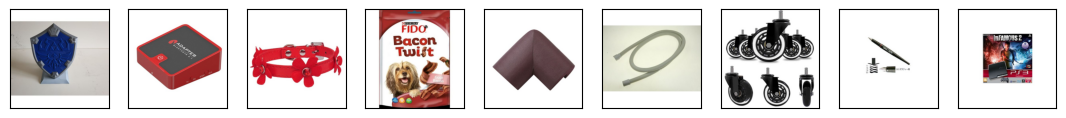

----------------------------------------------------------------------------------------------------------------------------------------------------


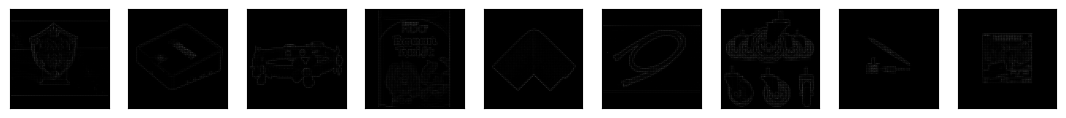

In [86]:
hog_ims = [hog(cv2.cvtColor(im, cv2.COLOR_RGB2GRAY), visualize=True)[1] for im in images]
images_grid(images[:9], 1, 9)
print('-'*148)
images_grid(hog_ims[:9], 1, 9 , cmap='gray')

In [87]:
def mean_hog_image(images):
    hog_features = []
    hog_images = []
    for im in images:
        feat, hog_img = hog(im, visualize=True)
        hog_images.append(hog_img)
    mean_hog = np.mean(hog_images, axis=0)
    return mean_hog

mean_hog = []

for code, cat in zip(codes, categories):
    # on charge le vecteur images de la categorie puis on applatit les images
    path = f"../data/exploration/images/{code}.npy"
    X = np.load(path)
    # on réduit les images en 32 x 32 en niveau de gris
    resizer = Resizer(dsize=(32,32), grayscale=True)
    X = resizer.fit_transform(X)
    mean_hog.append(mean_hog_image(X))

mean_hog = np.array(mean_hog)

-----------------------------------------------------------------  HOG moyen  -----------------------------------------------------------------


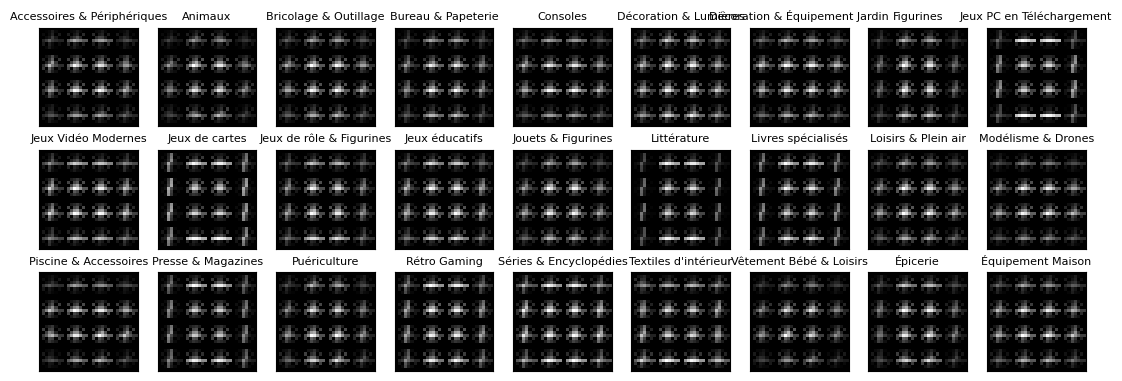

In [88]:
print('-'*65+"  HOG moyen  "+'-'*65)
images_grid(mean_hog, 3, 9, titles=categories, cmap='gray')

Nous allons créer un pipeline pour les HOG

In [26]:
hog_pipeline = Pipeline(steps=[('resizer', Resizer(dsize=(128, 128), grayscale=True)),
                               ('hog', HOGTransformer(orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2,2))),
                               ('scaler', StandardScaler()),
                               ('pca', PCA(n_components=150))])

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h2>3.5. Déscripteurs SIFT</h2>

<p>En plus des pipeline préalablement crée nous allons utiliser le transformateur <code>BoVWTransformer</code> qui utilise le principe du Bag of Visual Words.</p>

<p>
Le <strong>Bag of Visual Words (BoVW)</strong> représente une image par un <em>histogramme de motifs locaux</em>, appelés <strong>mots visuels</strong>. 
On commence par extraire des points clés et leurs descripteurs, ici des <strong>SIFT</strong>, puis on regroupe ces descripteurs pour former un dictionnaire de mots visuels. 
Chaque image est décrite par la fréquence de ces mots, ce qui permet de comparer ou classer les images.
</p>

<p>
Les <strong>descripteurs SIFT</strong> (Scale-Invariant Feature Transform) sont des vecteurs qui décrivent les motifs locaux autour des points clés, 
de manière robuste aux changements d'échelle, de rotation et d'illumination.
</p>


In [44]:
bovw = BoVWTransformer(n_clusters=100)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

# <h1 align="center">IV. Réduction de la dimension</h1>

## <h2>4.1. Projection LDA</h2>

<p>
Nous allons projeter les images, préalablement réduites à 36×36 pixels, dans un plan défini par les deux premières composantes de la LDA. 
Cette approche utilise des combinaisons linéaires des pixels pour maximiser la séparation entre les catégories tout en minimisant la variance à l’intérieur de chaque catégorie.
</p>

In [94]:
# fonction prise telle quelle du module "Méthodes de réduction de dimension - Manifold learning"

from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray_r', prefit = False):
    ax = ax or plt.gca()
    
    if not prefit :
        proj = model.fit_transform(data)
    else:
        proj = data
    ax.plot(proj[:, 0], proj[:, 1], '.b')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # On ne montre pas le points trop proches
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(cv2.resize(images[i], dsize = (28,28)), cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

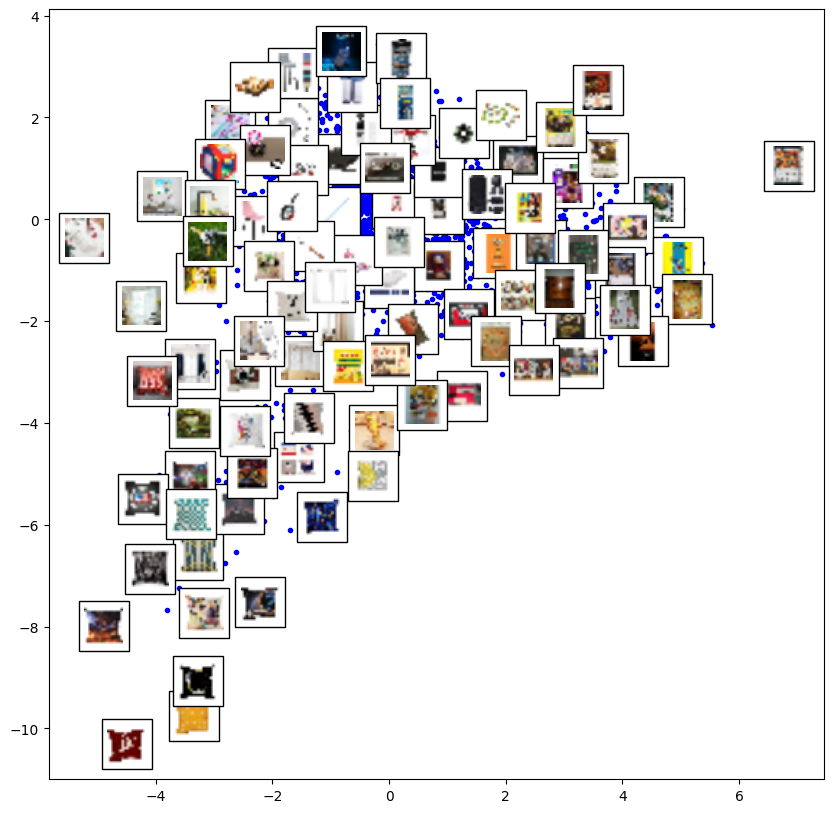

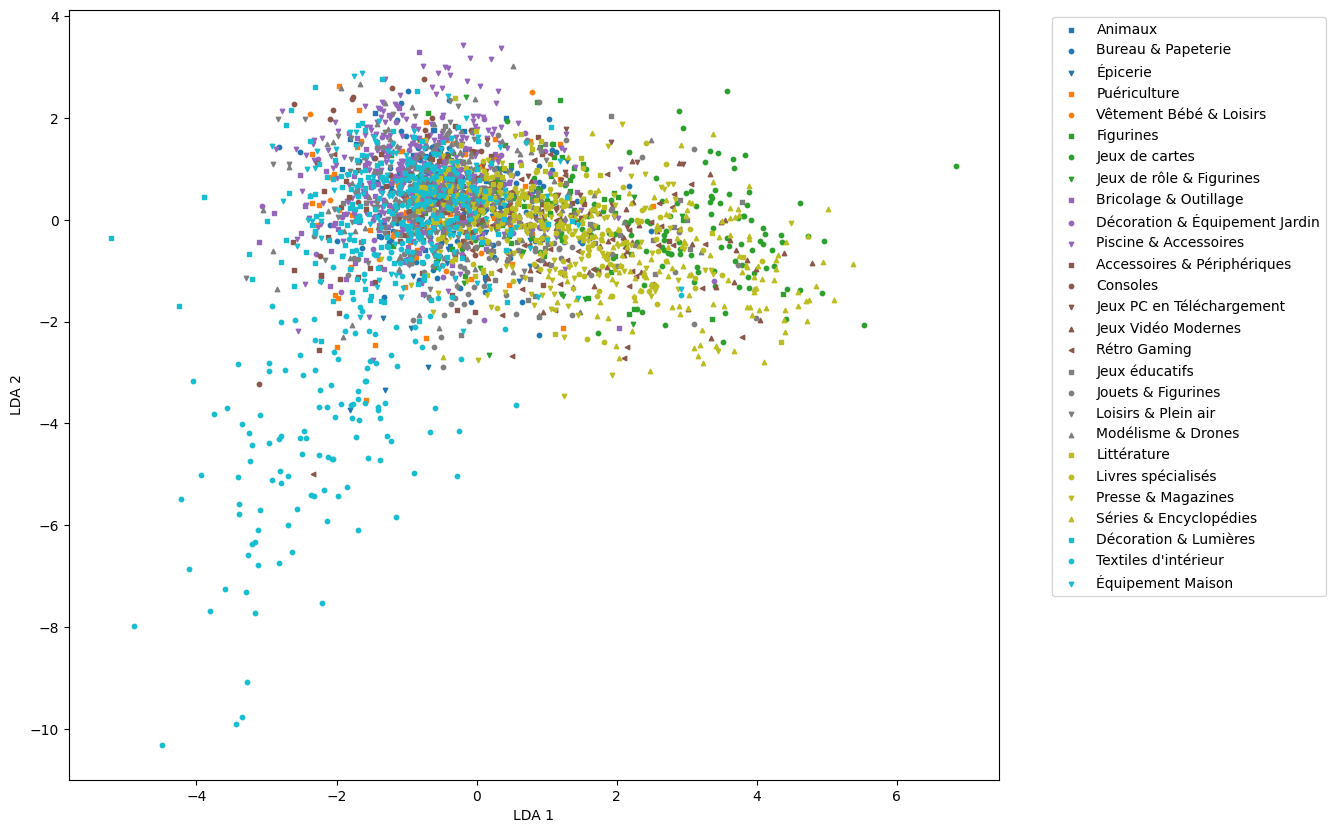

In [96]:
import matplotlib.markers as mmarkers

N = 3000
im28x28 = images_read(df['image'].iloc[:N], dsize=(16,16))
im28x28 = im28x28.reshape((im28x28.shape[0], -1))
lda = LDA(n_components=2)
lda.fit(im28x28, df['prdtypecode'][:N])
imt = lda.transform(im28x28)
fig, ax = plt.subplots(figsize=(10, 10))

# pour le nuage de points avec les images
plot_components(imt, lda, im28x28.reshape((-1,16,16,3)), prefit=True, ax=ax, thumb_frac=0.05)


# pour le deuxième nuage de points
data = pd.DataFrame({
    'x': imt[:, 0],
    'y': imt[:, 1],
    'groupe': df['group'].iloc[:len(imt)],
    'categorie': df['category'].iloc[:len(imt)]
})

groups = sorted(data['groupe'].unique())

cmap = plt.get_cmap("tab10")
colors = [cmap(i) for i in np.linspace(0, 1, len(groups))]
markers = list(mmarkers.MarkerStyle.markers.keys())[1:]

plt.figure(figsize=(12,10))

for i, group in enumerate(groups):
    cats = sorted(data[data['groupe']==group]['categorie'].unique())
    for j, cat in enumerate(cats):
        subset = data[(data["categorie"] == cat) & (data["groupe"] == group)]
        plt.scatter(subset["x"], subset['y'], color=colors[i], marker=markers[j], label=cat, s=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('LDA 1')
plt.ylabel('LDA 2')
plt.show()

<div style="background:#f0f8ff; padding:12px; border-radius:6px">



<p>
Seule la catégorie <strong>textile d'intérieur</strong> semble facilement se démarquer, située en bas à gauche. 
Dans cette catégorie, ce sont principalement les images de <strong>coussins</strong> et d'<strong>oreillers</strong> qui apparaissent comme discriminantes.
</p>

<p>
En haut à droite, on observe des objets plus rectangulaires, souvent des <strong>livres</strong> et des <strong>revues</strong>.
</p>

<p>
Nous allons maintenant ajouter un pipeline avec une <strong>LDA</strong> appliquée directement sur les images brutes.
</p>


In [31]:
# image réduite en couleur brute applatit et réduite par LDA => 26 features
colors_lda_pipeline = Pipeline(steps=[('resizer', Resizer(dsize=(16,16))),
                                      ('flattener', Flattener()),
                                      ('scaler', StandardScaler()),
                                      ('lda', LDA(n_components=26))])

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

# <h1 align="center">V. Modèle de base</h1>

Nous allons maintenant utiliser l'ensemble des features crée par nos transformateur. Pour celà nous allons faire une  dans un mais nous allons utiliser une instance de <code>FeatureUnion</code> qui prend l'ensemble de nos transformeur. Puis nous allons ajouter au préalable un pipeline de préparation qui réduira recadrera et réduira les images en 128x128x3préalable réduire la dimensions de l'image et en sortie un modèle de régression logistique. Ca donne le shéma suivant.


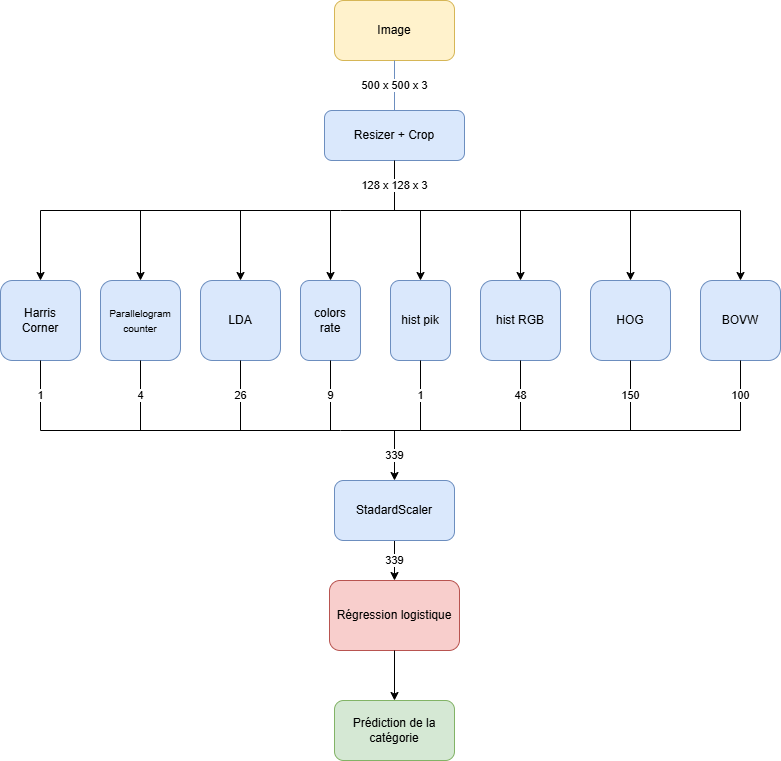

In [37]:
#cleaner = Cleaner(max_bg_ratio=0.85, white_bg=True, padding=5, min_len_ratio=0.2, min_vertex=3, n_max_contours=7)
resize_crop = Pipeline(steps=[('crop', CropTransformer()), ('resizer', Resizer((128,128)))])

union = FeatureUnion(transformer_list=[('corner_counter', corner_counter),                # 1 feature
                                       ('parallelogram_counter', parallelogram_counter),  # 4 features
                                       ('hog_pipeline', hog_pipeline),                    # 150 features
                                       ('bovw', bovw),                                    # 100 features
                                       ('colors_lda_pipeline', colors_lda_pipeline),      # 26 features
                                       ('colors_rate_pipeline', colors_rate_pipeline),    # 9 features
                                       ('histrgb_pipeline', histrgb),                     # 48 features
                                       ('hist_diff_pipeline', hist_diff_pipeline),        # 1 feature
                                      ])


final_pipeline = Pipeline(steps=[('resize_crop', resize_crop),
                                 ('union', union),
                                 # toute les features qui sorte d'union sont quantitatives on peut donc les standardiser
                                 ('scaler', StandardScaler()),
                                 ('lr', LogisticRegression(max_iter=12000, C=0.001, class_weight='balanced'))])

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

Maintenant que nous avons fait notre pipeline nous allons entrainer le modèle.

In [34]:
X = df['image']
y = df['category']
# le split est en deux fois pour avoir les mêmes jeux de test sur qu'avec le deep learning
# où j'utiliserai la première des deux ligne pour spliter le jeu de test
X, X_test, y, y_test = train_test_split(X, y, test_size=5000, stratify=y, random_state=1)
X_train, _, y_train, _ = train_test_split(X, y, train_size=15000, stratify=y, random_state=1)

# pour ne pas encombré la mémoire inutilement on récupère les images en 128 x 128
# au lieu de les avoir brut en 500 x 500 et appliqué la réduction en 128 x 128 dans le pipeline
X_train = images_read(X_train, dsize=(128, 128), max_load=2*10**9)
X_test = images_read(X_test, dsize=(128, 128), max_load=2*10**9)

target_encoder = LabelEncoder()
y_train = target_encoder.fit_transform(y_train)
y_test = target_encoder.transform(y_test)

f1 weighted train score :  0.5907174462679918
f1 weighted test score : 0.3741962370628623        (46.13 s pour 5000 prédictions)
accuracy : 0.36


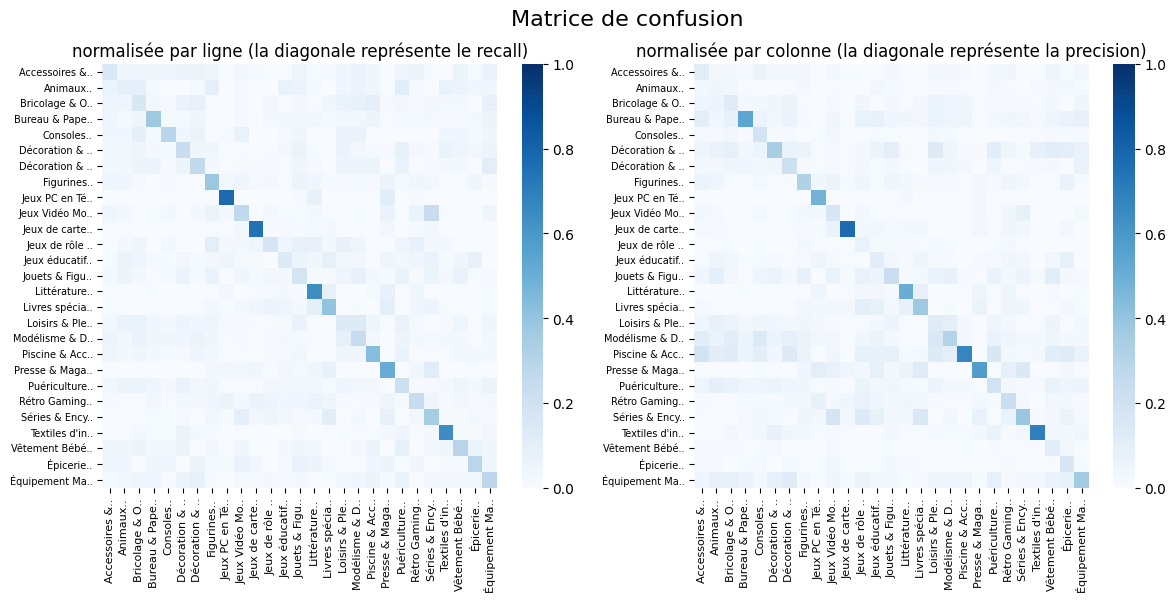

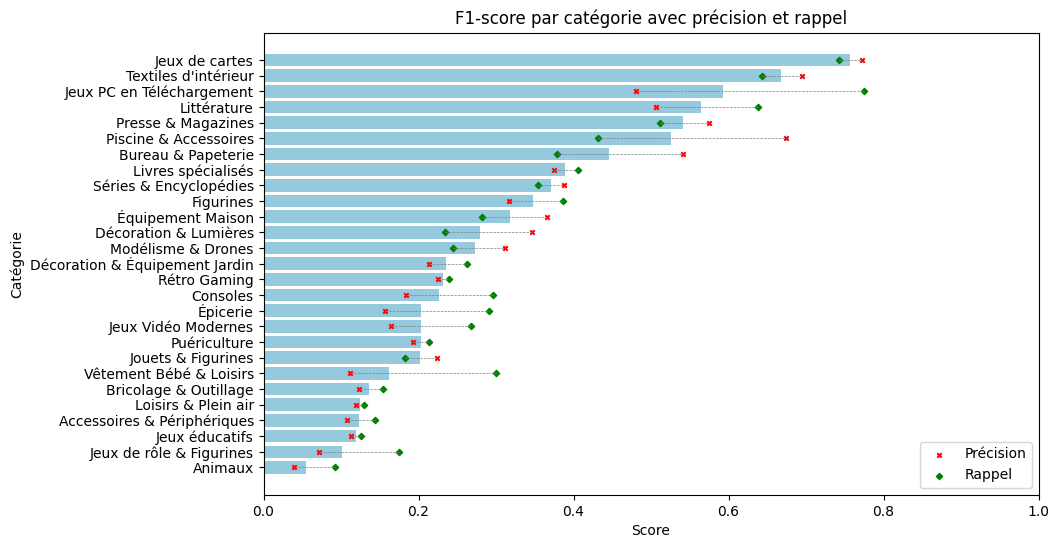

In [104]:
final_pipeline.fit(X_train, y_train)
report = print_scores(final_pipeline, X_test, y_test, X_train, y_train, encoder=target_encoder, plot=True)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>Nous pouvons observer que les images permettent de distinguer correctement certaines catégories, telles que les <strong>livres</strong>, les <strong>jeux de cartes</strong> et les <strong>textiles d'intérieur</strong>. Cependant, il reste plus difficile de prédire les images des catégories <strong>animaux</strong> et <strong>jeux et jouets</strong>.</p>

<p>Les résultats obtenus semblent assez cohérents avec l'analyse faite précédemment : les catégories comme <strong>jeux de cartes</strong>, <strong>textiles d'intérieur</strong>, <strong>jeux de PC</strong> ou <strong>littérature</strong> présentent de fortes caractéristiques liées à leurs formes, tandis que la catégorie <strong>piscine</strong> se distingue par la prédominance du <em>bleu</em> dans les images, ce qui semble expliquer les bons résultats obtenus pour ces catégories.</p>

<p>Il est donc logique que ces catégories aient les meilleurs scores, étant donné que leurs caractéristiques visuelles sont plus facilement identifiables par le modèle.</p>

<p>Nous allons maintenant analyser l'importance des features dans le modèle, en examinant la valeur absolue des coefficients, qui sont représentées sur les heatmaps ci-dessous.</p>


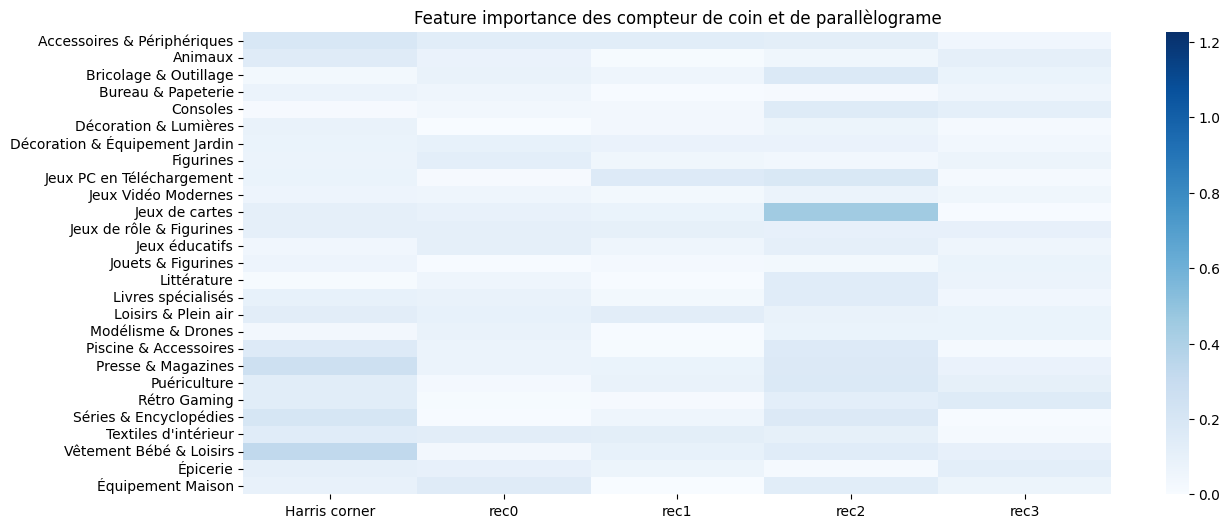

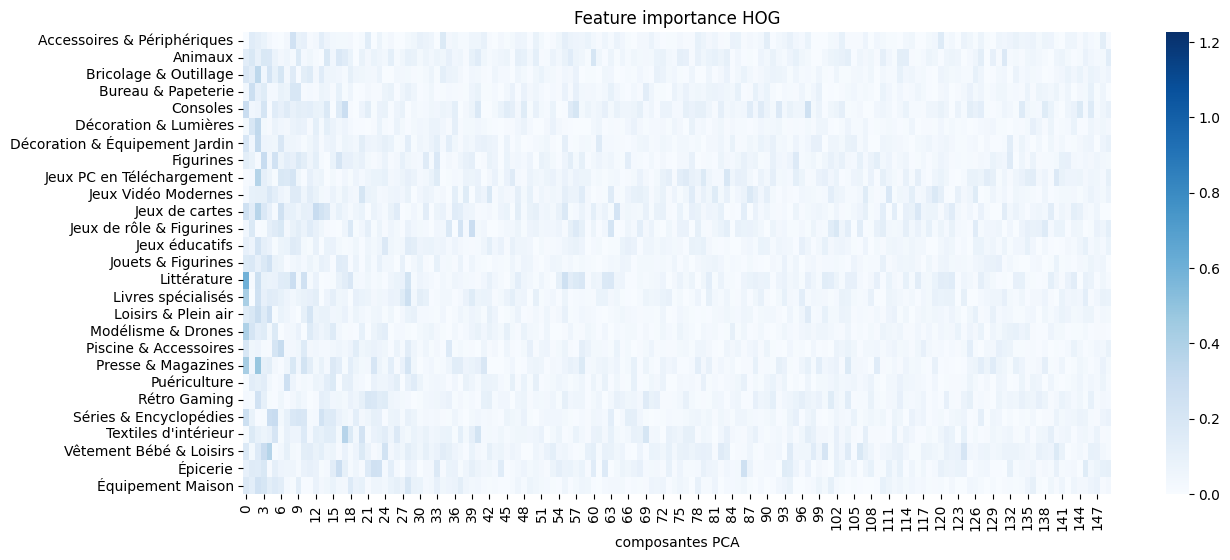

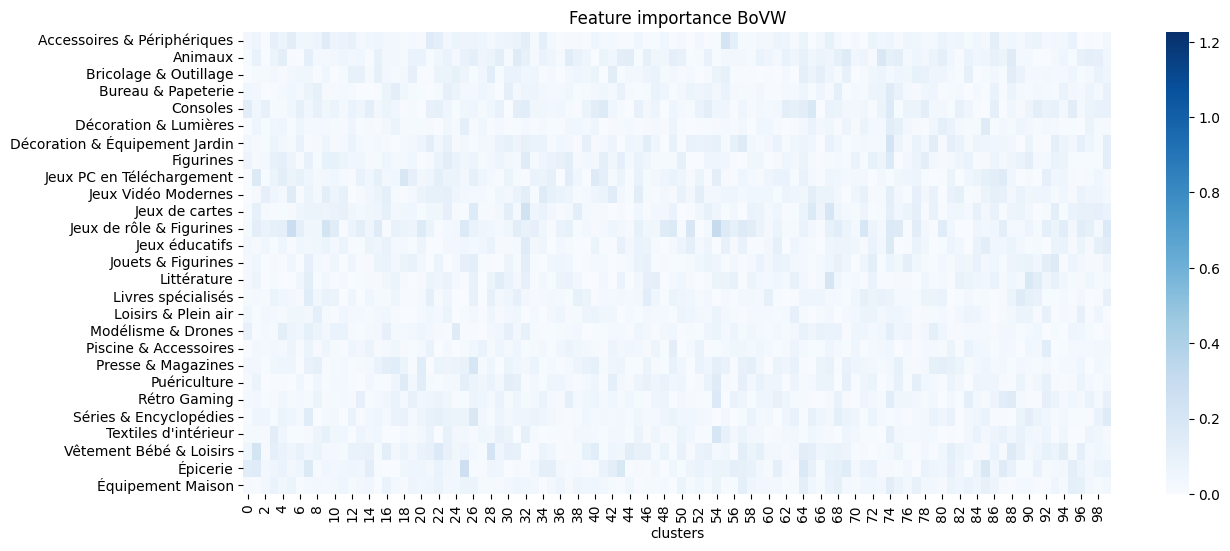

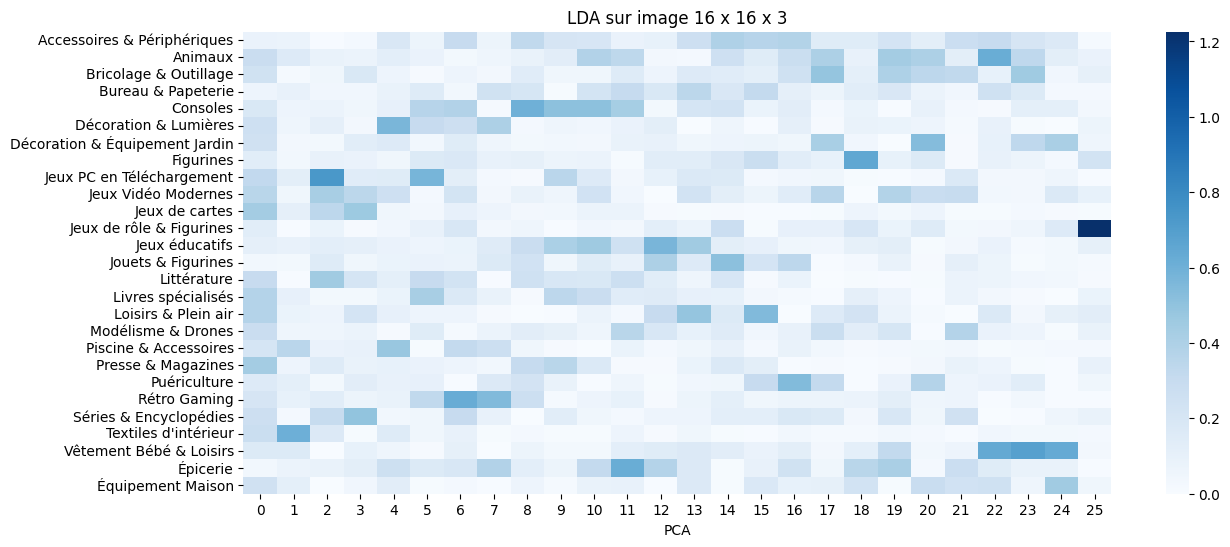

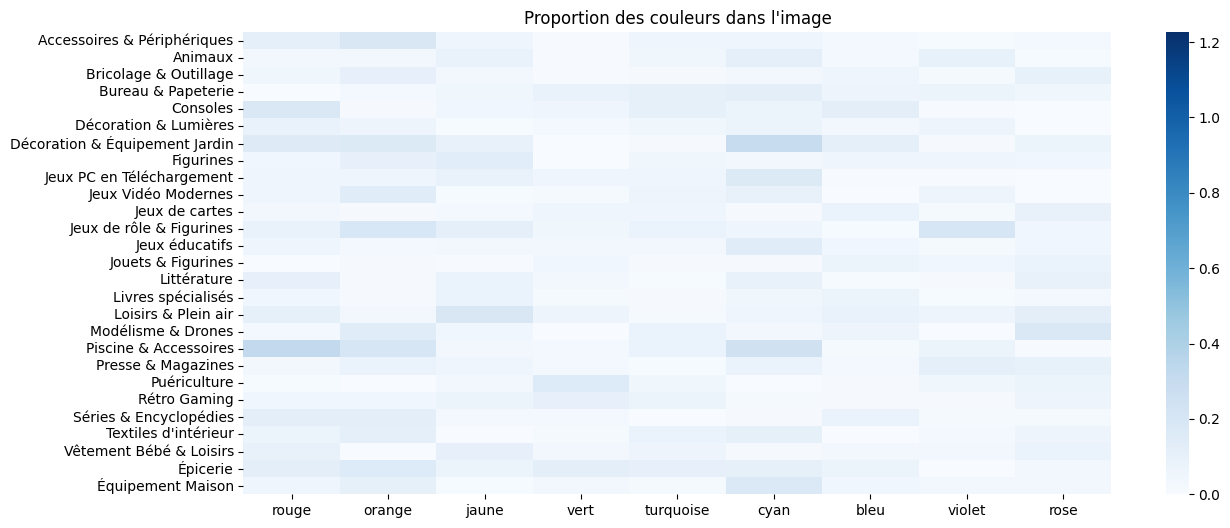

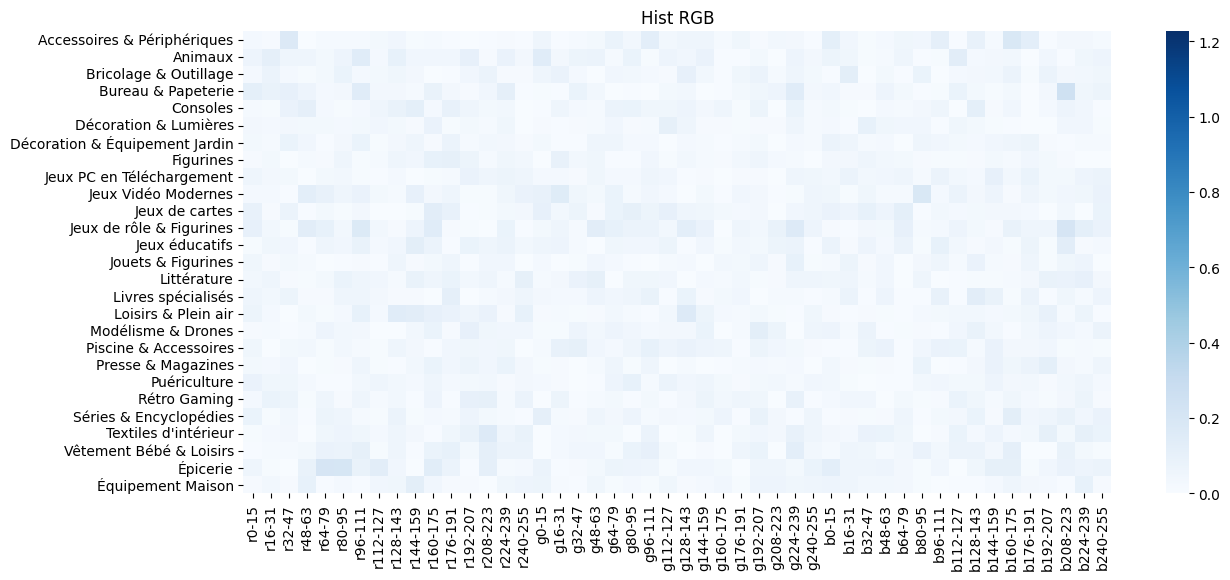

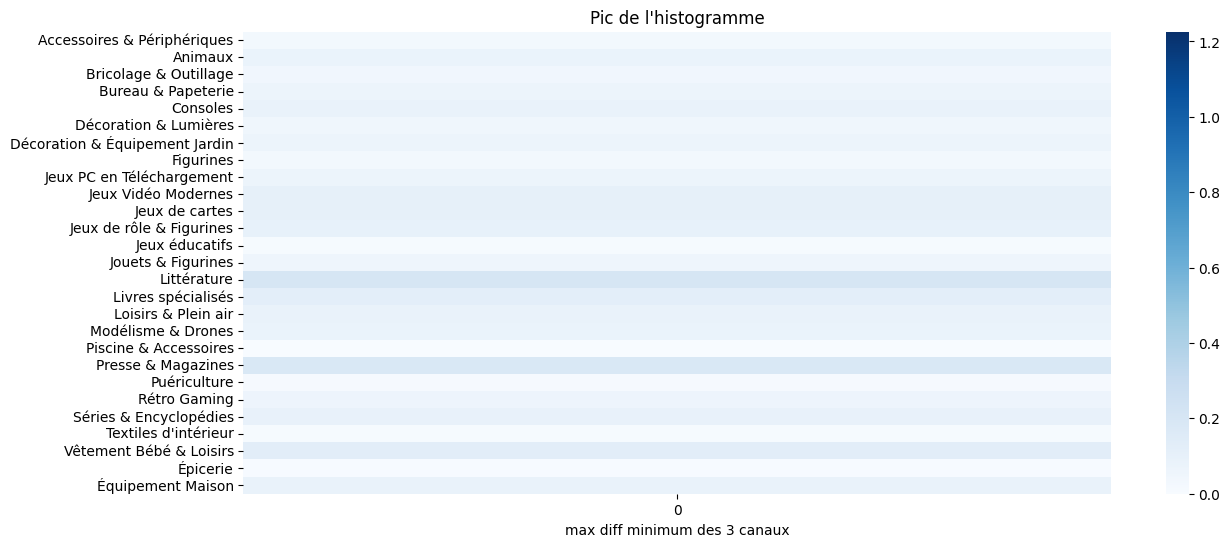

In [148]:
coef = final_pipeline.named_steps['lr'].coef_
abs_coef = np.abs(coef)

M = abs_coef.max()

k = 5  # taille du bloc
a, b = 0, k


cmap = 'Blues'
plt.figure(figsize=(14,6))
sns.heatmap(abs_coef[:,a:b], vmin=0, vmax=M, cmap=cmap)
labels = target_encoder.inverse_transform(range(27))
# +0.5 pour centrer les labels sur les ticks
plt.title("Feature importance des compteur de coin et de parallèlograme")
plt.yticks(np.arange(27) + 0.5, labels=labels, rotation=0);
plt.xticks(np.arange(5) + 0.5, labels=['Harris corner'] + [f"rec{i}"for i in range(4)], rotation=0)
plt.show()

k = 150
a, b = b, b+k

plt.figure(figsize=(14,6))

sns.heatmap(abs_coef[:,a:b], vmin=0, vmax=M, cmap=cmap)
labels = target_encoder.inverse_transform(range(27))
# +0.5 pour centrer les labels sur les ticks
plt.title("Feature importance HOG")
plt.yticks(np.arange(27) + 0.5, labels=labels, rotation=0)
plt.xlabel('composantes PCA')
plt.show()

k = 100
a, b = b, b+k

plt.figure(figsize=(14,6))
sns.heatmap(abs_coef[:,a:b], vmin=0, vmax=M, cmap=cmap)
labels = target_encoder.inverse_transform(range(27))
# +0.5 pour centrer les labels sur les ticks
plt.title("Feature importance BoVW")
plt.yticks(np.arange(27) + 0.5, labels=labels)
plt.xlabel('clusters')
plt.show()

k = 26
a, b = b, b+k

plt.figure(figsize=(14,6))
sns.heatmap(abs_coef[:,a:b], vmin=0, vmax=M, cmap=cmap)
plt.title("LDA sur image 16 x 16 x 3")
labels = target_encoder.inverse_transform(range(27))
plt.yticks(np.arange(27) + 0.5, labels=labels)
plt.xlabel('PCA')
plt.show()

k = 9
a, b = b, b+k

plt.figure(figsize=(14,6))
sns.heatmap(abs_coef[:,a:b], vmin=0, vmax=M, cmap=cmap)
plt.title("Proportion des couleurs dans l'image")
labels = target_encoder.inverse_transform(range(27))
plt.yticks(np.arange(27) + 0.5, labels=labels)
labels = ['rouge', 'orange', 'jaune', 'vert', 'turquoise', 'cyan', 'bleu', 'violet', 'rose']
plt.xticks(np.arange(9) + 0.5, labels=labels)
plt.show()

k = 48
a, b = b, b+k

plt.figure(figsize=(14,6))
sns.heatmap(abs_coef[:,a:b], vmin=0, vmax=M, cmap=cmap)
labels = target_encoder.inverse_transform(range(27))
# +0.5 pour centrer les labels sur les ticks
plt.title("Hist RGB")
plt.yticks(np.arange(27) + 0.5, labels=labels)
labels = [[f"{c}{i*16}-{i*16+15}" for i in range(16)] for c in 'rgb']
plt.xticks(np.arange(48) + 0.5, labels=np.hstack(labels), rotation=90)
plt.show()

k = 1
a, b = b, b+k

plt.figure(figsize=(14,6))
sns.heatmap(abs_coef[:,a:b], vmin=0, vmax=M, cmap=cmap)
plt.title("Pic de l'histogramme")
labels = target_encoder.inverse_transform(range(27))
plt.yticks(np.arange(27) + 0.5, labels=labels)
plt.xlabel('max diff minimum des 3 canaux')
plt.show()

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>On observe que la réduction de l'image brute (uniquement réduite) par LDA joue un rôle important pour le modèle. Ce n'est pas surprenant, car la réduction LDA optimise la séparabilité des classes spécifiquement pour le jeu d'entraînement, ces composantes sont donc en général importante pour pendant la phase d'entraînement même si elle ne se généralise pas aussi bien sur le jeu de test.</p>

<p>
On constate que plusieurs coefficients associés aux composantes issues de la LDA prennent des valeurs importantes dans le modèle. Cela est cohérent avec le fait que la LDA construit des axes explicitement optimisés pour maximiser la séparabilité des classes sur le jeu d’entraînement. Ces composantes capturent donc une structure discriminante forte, ce qui explique qu’elles pèsent davantage dans le modèle, même si cette pertinence ne se traduit pas toujours par une bonne généralisation sur le jeu de test.
</p>

<p>
En revanche, la réduction <strong>PCA</strong> appliquée sur les <strong>HOG</strong> semble également important pour le modèle. En effet, on constate que les premières composantes principales ont un poids particulièrement élevé dans le modèle, ce qui suggère qu'elles contiennent des informations cruciales pour la classification.</p>

<p>Enfin, il est intéressant de noter que la proportion de <strong>bleu</strong> dans les images ne semble pas être un facteur aussi déterminant pour expliquer la catégorie <strong>piscine</strong> que prévu. Cela pourrait être dû au fait que cette caractéristique est déjà capturée par d'autres <em>features</em> comme le faible taux de rouge où l'on observe des coefficients relativement élevés pour cette catégorie.</p>

<p>
Les pics des histogrammes RGB jouent un rôle discriminant important pour distinguer Littératures de Presse & Magazines. Comme nous l'avons vu les ouvrages de Littératures présentent souvent des histogrammes très marqués (coefficient positif), tandis que ceux de Presse & Magazines sont généralement plus lisses (coefficient négatif).
</p>